In [1]:
import glob
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.hp_tuning_functions import *
from src.plot_functions import *
import pandas as pd
from darts import TimeSeries, concatenate
import matplotlib.pyplot as plt

In [2]:
from darts.models.forecasting.lgbm import LightGBMModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


# Load data

In [3]:
ts_target = load_target_series()

<Axes: xlabel='date'>

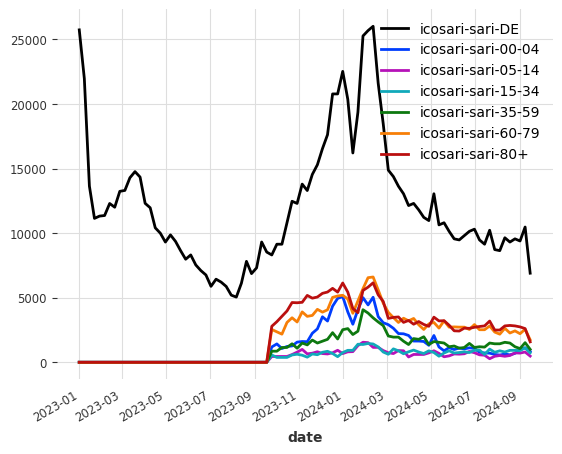

In [4]:
ts_target.plot()

In [5]:
ts_nowcast = load_nowcast('2024-01-25')

In [6]:
target_list = make_target_paths(ts_target, ts_nowcast)

<Axes: xlabel='date'>

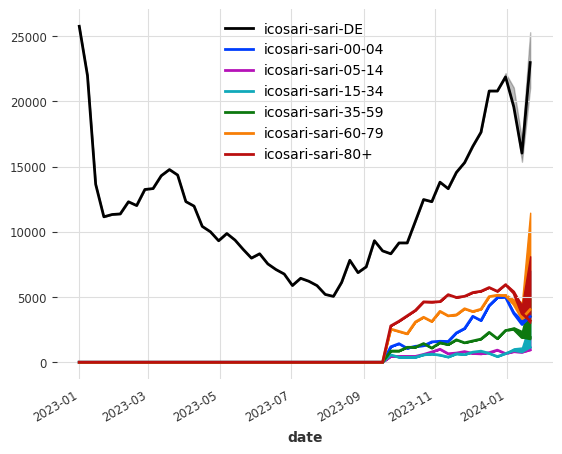

In [7]:
concatenate(target_list, axis='sample').plot()

# Train model

In [8]:
HORIZON = 4
NUM_SAMPLES = 1000

In [9]:
ENCODERS = {
    'datetime_attribute': {'future': ['month', 'weekofyear']}
}

In [10]:
params = get_best_parameters('lightgbm-simple-cv-test', 'lightgbm')

WIS of best run: 185.67070007218177


In [11]:
params = get_best_parameters('lightgbm-simple-cv-test', 'lightgbm', use_covariates=False, lags=8)

WIS of best run: 194.98528191429205


In [11]:
params = get_best_parameters('lightgbm-simple-cv-test', 'lightgbm', use_covariates=False)

WIS of best run: 194.98528191429205


In [12]:
params = get_best_parameters('lightgbm-simple-cv-test', 'lightgbm', multiple_series=False, use_covariates=False)

WIS of best run: 199.43773438445027


In [11]:
params

{'lags': 16,
 'model': 'lightgbm',
 'max_bin': 1024,
 'max_depth': 5,
 'reg_alpha': 0,
 'subsample': 1,
 'test_year': 2019,
 'num_leaves': 40,
 'reg_lambda': 0,
 'n_estimators': 5000,
 'use_encoders': True,
 'use_features': False,
 'learning_rate': 0.05,
 'min_split_gain': 0,
 'subsample_freq': 0,
 'use_covariates': True,
 'multiple_series': False,
 'colsample_bytree': 1,
 'min_child_samples': 30,
 'lags_past_covariates': 8,
 'use_static_covariates': True,
 'lags_future_covariates': [0, 4]}

In [12]:
name = params.pop('model')
multiple_series = params.pop('multiple_series')
use_covariates = params.pop('use_covariates')
use_features = params.pop('use_features')
use_encoders = params.pop('use_encoders')

In [13]:
# use_features = True

In [14]:
if not use_covariates:
    del params['lags_past_covariates']

In [15]:
model = LightGBMModel(
    **params,
    output_chunk_length=4,
    add_encoders=ENCODERS if use_encoders else None,
    likelihood="quantile",
    quantiles=QUANTILES,
    verbose=-1
)

In [16]:
ts = load_data(SOURCES)
ts, covariates = target_covariate_split(ts, TARGETS)
ts = ts[ : SEASON_DICT[2019]] # train pre-covid

In [17]:
ts = encode_static_covariates(ts, ordinal=False)

In [18]:
#ts = ts[ : pd.Timestamp('2023-07-31')] # include covid period in training

In [19]:
if multiple_series:
    ts = [ts[col] for col in ts.columns]

if use_features:
    ts_features = load_features(lag=8)
    covariates = covariates.slice_intersect(ts_features) # features start a bit later because of rolling window
    if multiple_series:
        ts_features = [ts_features[[col for col in ts_features.columns if target in col]] for target in TARGETS] # has to be in the same order as the target series!
        covariates = [concatenate([covariates.with_static_covariates(None), features_age], axis='component') for features_age in ts_features]
    else:
        covariates = concatenate([covariates.with_static_covariates(None), ts_features], axis='component')
else:
    if multiple_series:
        covariates = [covariates]*len(ts)

In [20]:
multiple_series

False

In [21]:
len(covariates)

518

In [22]:
# if use_features:
#     ts_features = ts_features.slice_intersect(covariates)
#     covariates = covariates.slice_intersect(ts_features)
#     covariates = concatenate([covariates.with_static_covariates(None), ts_features], axis='component')

In [23]:
# if multiple_series returns a list with a feature timeseries per target
# otherwise they are concatenated into one multivariate feature timeseries

# ts_features = load_features(lag=8, multiple_series=False)

In [24]:
# covariates = covariates.slice_intersect(ts_features) # features start a bit later because of rolling window

In [25]:
# if multiple_series:
#     ts = [ts[col] for col in ts.columns]

#     if use_features:
#         ts_features = load_features(lag=8)
#         ts_features = [ts_features[[col for col in ts_features.columns if target in col]] for target in TARGETS]
#         covariates = [concatenate([covariates.with_static_covariates(None), features_age], axis='component') for features_age in ts_features]
    
# else:
#     if use_features:
#         ts_features = load_features(lag=8)
#         covariates = covariates.slice_intersect(ts_features) # features start a bit later because of rolling window
#         covariates = concatenate([covariates.with_static_covariates(None), ts_features], axis='component')

In [26]:
covariates.columns

Index(['survstat-influenza-DE', 'survstat-influenza-00-04',
       'survstat-influenza-05-14', 'survstat-influenza-15-34',
       'survstat-influenza-35-59', 'survstat-influenza-60-79',
       'survstat-influenza-80+', 'survstat-influenza-DE-BB-BE',
       'survstat-influenza-DE-BW', 'survstat-influenza-DE-BY',
       'survstat-influenza-DE-HE', 'survstat-influenza-DE-MV',
       'survstat-influenza-DE-NI-HB', 'survstat-influenza-DE-NW',
       'survstat-influenza-DE-RP-SL', 'survstat-influenza-DE-SH-HH',
       'survstat-influenza-DE-SN', 'survstat-influenza-DE-ST',
       'survstat-influenza-DE-TH', 'agi-are-DE', 'agi-are-00-04',
       'agi-are-05-14', 'agi-are-15-34', 'agi-are-35-59', 'agi-are-60+'],
      dtype='object', name='component')

In [27]:
# ts.plot()

In [28]:
# ts['icosari-sari-DE'].plot()
# covariates['survstat-influenza-DE'].plot()
# covariates['agi-are-DE'].plot()

In [29]:
model.fit(ts, past_covariates=covariates if use_covariates else None)

LightGBMModel(lags=16, lags_past_covariates=8, lags_future_covariates=[0, 4], output_chunk_length=4, output_chunk_shift=0, add_encoders={'datetime_attribute': {'future': ['month', 'weekofyear']}}, likelihood=quantile, quantiles=[0.025, 0.25, 0.5, 0.75, 0.975], random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None, max_bin=1024, max_depth=5, reg_alpha=0, subsample=1, test_year=2019, num_leaves=40, reg_lambda=0, n_estimators=5000, learning_rate=0.05, min_split_gain=0, subsample_freq=0, colsample_bytree=1, min_child_samples=30, verbose=-1)

In [32]:
MODEL_PATH = f'../models/post-covid/{name}2{"-multiple_series" if multiple_series else ""}{"-no_covariates" if not use_covariates else ""}.pt'

In [33]:
MODEL_PATH

'../models/post-covid/lightgbm2.pt'

In [34]:
model.save(MODEL_PATH)

# Forecast

In [46]:
def compute_forecast(model, target_series, covariates, forecast_date, horizon, num_samples, multiple_series, probabilistic_nowcast=True):
    '''
    For every sample path given by the nowcasted quantiles, a probabilistic forecast is computed.
    These are then aggregated into one forecast by combining all predicted paths.
    '''
    ts_nowcast = load_nowcast(forecast_date, probabilistic_nowcast)
    target_list = make_target_paths(target_series, ts_nowcast)
    target_list = [encode_static_covariates(t, ordinal=False) for t in target_list]
    #print(len(target_list))
    
    if multiple_series:
        target_list = [ts[col] for ts in target_list for col in ts.columns] # all age groups per sample
        covariates = covariates*len(target_list) if covariates else None
        
    covariates = [covariates]*len(target_list) if covariates else None
    #print(len(covariates))
        
    fct = model.predict(n=horizon, 
                        series=target_list, 
                        past_covariates=covariates, 
                        num_samples=num_samples)
    
    if multiple_series:
        fct = [concatenate(fct[i:i+ts_target.n_components], axis='component') 
               for i in range(0, len(fct), ts_target.n_components)]
    
    ts_forecast = concatenate(fct, axis='sample')
    
    return ts_forecast

In [36]:
ts_target = load_target_series()

In [37]:
ts = load_data(SOURCES, end_date=ts_target.end_time())
ts, covariates = target_covariate_split(ts, TARGETS)

In [42]:
forecast = compute_forecast(model, ts_target, covariates if use_covariates else None, '2024-03-21', HORIZON, NUM_SAMPLES, multiple_series)

<Axes: xlabel='date'>

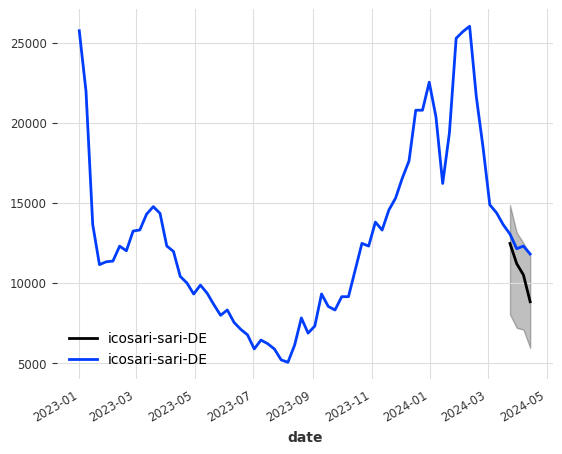

In [43]:
forecast['icosari-sari-DE'].plot()
ts_target['icosari-sari-DE'].drop_after(forecast.end_time() + pd.Timedelta(weeks=1)).plot()

In [47]:
forecast = compute_forecast(model, ts_target, covariates if use_covariates else None, '2024-03-21', HORIZON, NUM_SAMPLES, multiple_series, probabilistic_nowcast=False)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


<Axes: xlabel='date'>

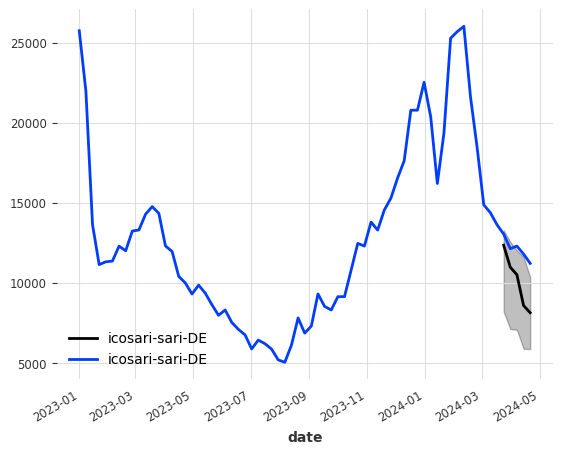

In [48]:
forecast['icosari-sari-DE'].plot()
ts_target['icosari-sari-DE'].drop_after(forecast.end_time() + pd.Timedelta(weeks=1)).plot()

In [51]:
forecast

<TimeSeries (DataArray) (date: 5, component: 7, sample: 1000)>
array([[[13287.12443534, 12599.89118697, 10259.3160813 , ...,
         10598.90892404, 12772.84017481, 10904.33614511],
        [ 1584.56789692,  1505.66167769,  1916.81913021, ...,
          1493.32032903,  2166.5521737 ,  1242.97827559],
        [  519.34188221,   740.29586087,   424.74039225, ...,
           193.7756143 ,   692.04009405,   537.64088117],
        ...,
        [ 1538.65045369,  1399.90870248,  1216.72496006, ...,
          1795.852634  ,  1486.22559545,  1734.54079958],
        [ 3233.46658025,  3250.54572912,  2489.64988164, ...,
          3518.23283973,  3404.77729421,  3491.44855074],
        [ 3574.54352419,  3757.09361464,  3573.19695257, ...,
          2221.29141647,  3548.06779734,  2715.72378542]],

       [[10554.72561319, 12357.10376289,  9252.58757678, ...,
         12688.17782336, 11013.10045781,  9276.91852158],
        [ 1586.18645804,  1672.80785374,  1801.39585552, ...,
          2434.93210553,  2404.57693161,  1757.50202556],
        [  295.99586643,   216.85018915,   235.82826794, ...,
           204.47424516,   292.49524704,   133.11139859],
...
        [  686.49460786,   711.30115414,   901.63588967, ...,
          1429.44653739,  1192.79929951,  1085.65636136],
        [ 2540.89500399,  2657.10231198,  2882.29854249, ...,
          2406.27154668,  2742.70359393,  2022.06405624],
        [ 2384.85577327,  3105.90860583,  2022.43786668, ...,
          2651.81719008,  2704.09549128,  2730.77505223]],

       [[ 6985.49870056,  6103.19027089,  7415.46763505, ...,
         10179.14937147, 10564.8721618 ,  5835.17489013],
        [  648.07941934,   213.25245629,   933.7913568 , ...,
          1390.32133689,  1607.59659857,   398.69021427],
        [  156.27068771,   158.0791989 ,   187.1429894 , ...,
           235.58308686,   307.31246471,   120.53613786],
        ...,
        [ 1383.94978651,  1015.47816599,   794.12245078, ...,
          1218.48887308,   806.09049804,  1250.06196532],
        [ 2866.30939939,  2900.81157075,  2473.38055433, ...,
          2085.84056503,  2902.61168048,  2537.45413117],
        [ 3004.58461657,  3244.34187118,  1927.70473426, ...,
          2272.96455917,  2896.7250109 ,  3009.34947962]]])
Coordinates:
  * date       (date) datetime64[ns] 2024-03-24 2024-03-31 ... 2024-04-21
  * component  (component) object 'icosari-sari-DE' ... 'icosari-sari-80+'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates   age_group_00+  age_group_00-04  a...
    hierarchy:          None

<Axes: xlabel='date'>

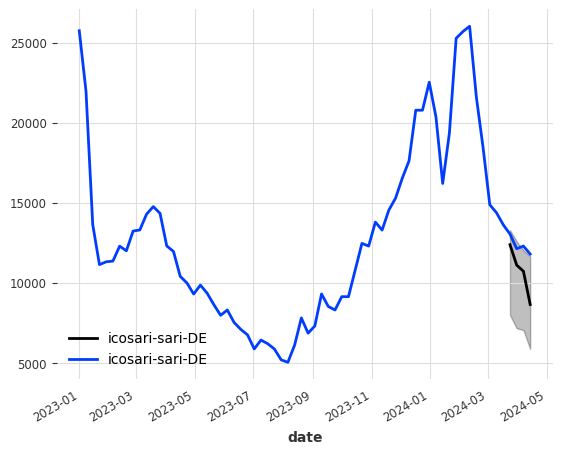

In [45]:
forecast['icosari-sari-DE'].plot()
ts_target['icosari-sari-DE'].drop_after(forecast.end_time() + pd.Timedelta(weeks=1)).plot()

In [44]:
forecast_dates = sorted([filename.split('/')[-1][:10] for filename in glob.glob('../data/nowcasts/KIT-baseline/*.csv')])
forecast_dates = [date for date in forecast_dates if date > '2023-11-09']

In [45]:
forecasts = []

for forecast_date in forecast_dates:
    print(forecast_date)
    forecast = compute_forecast(model, ts_target, covariates if use_covariates else None, forecast_date, HORIZON, NUM_SAMPLES, multiple_series)
    forecasts.append(forecast)

2023-11-16
2023-11-23
2023-11-30
2023-12-07
2023-12-14
2023-12-21
2023-12-28
2024-01-04
2024-01-11
2024-01-18
2024-01-25
2024-02-01
2024-02-08
2024-02-15
2024-02-22
2024-02-29
2024-03-07
2024-03-14
2024-03-21
2024-03-28
2024-04-04
2024-04-11
2024-04-18
2024-04-25
2024-05-02
2024-05-09
2024-05-16
2024-05-23
2024-05-30
2024-06-06


In [46]:
df = reshape_hfc(forecasts)

In [47]:
HFC_PATH = f'../data/post-covid/{name}{"-multiple_series" if multiple_series else ""}{"-no_covariates" if not use_covariates else ""}.csv'

In [48]:
HFC_PATH

'../data/post-covid/lightgbm-no_covariates.csv'

In [49]:
df.to_csv(HFC_PATH, index=False)

In [50]:
df_plot = prepare_plot_data(df, ts_target[df.target_end_date.min(): df.target_end_date.max()])

In [51]:
multiple_series, use_covariates, use_features, use_encoders

(False, False, True, True)

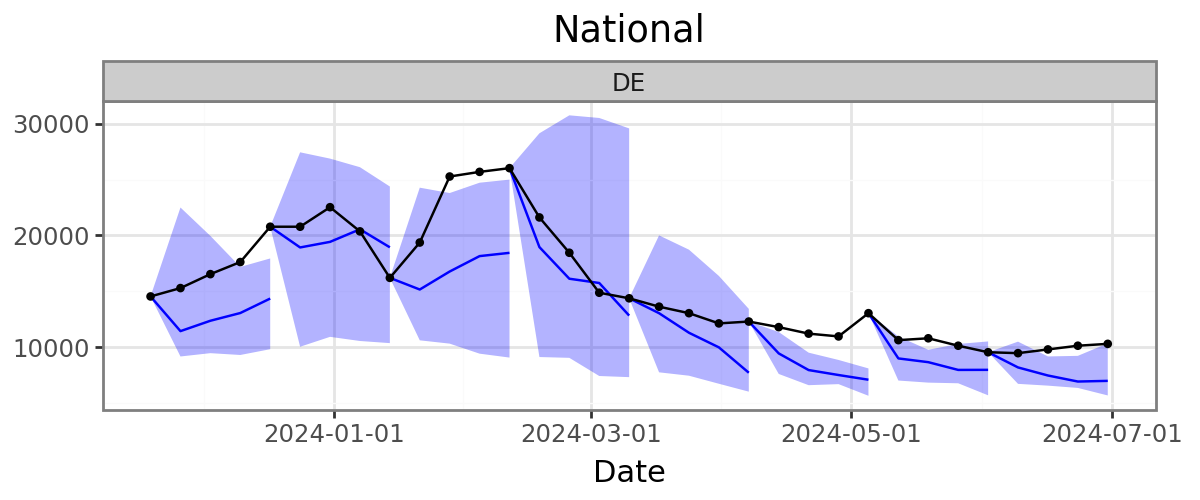

In [52]:
plot_forecasts(df_plot, 'national', start=1, stride=4)

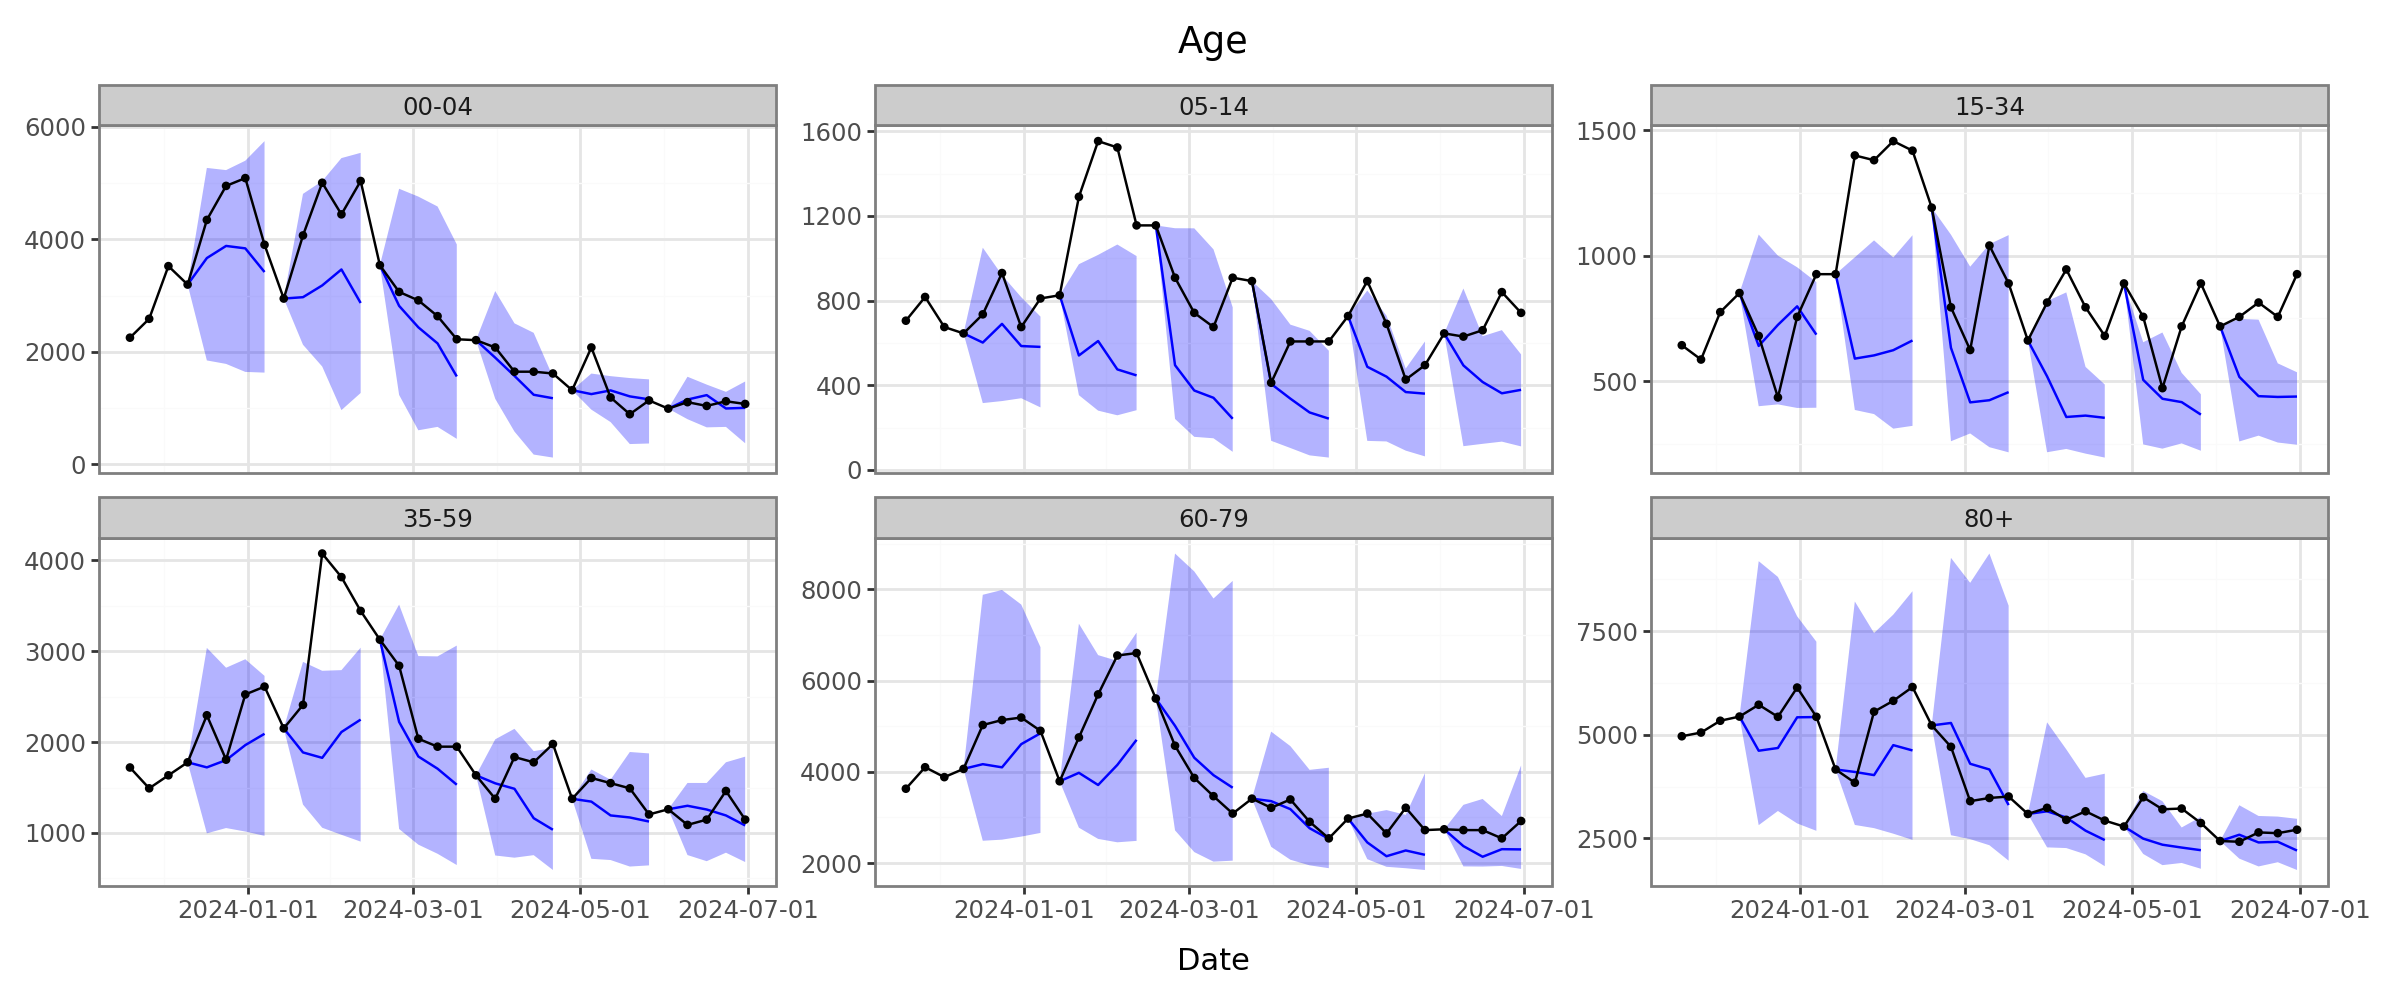

In [53]:
plot_forecasts(df_plot, 'age', start=4)

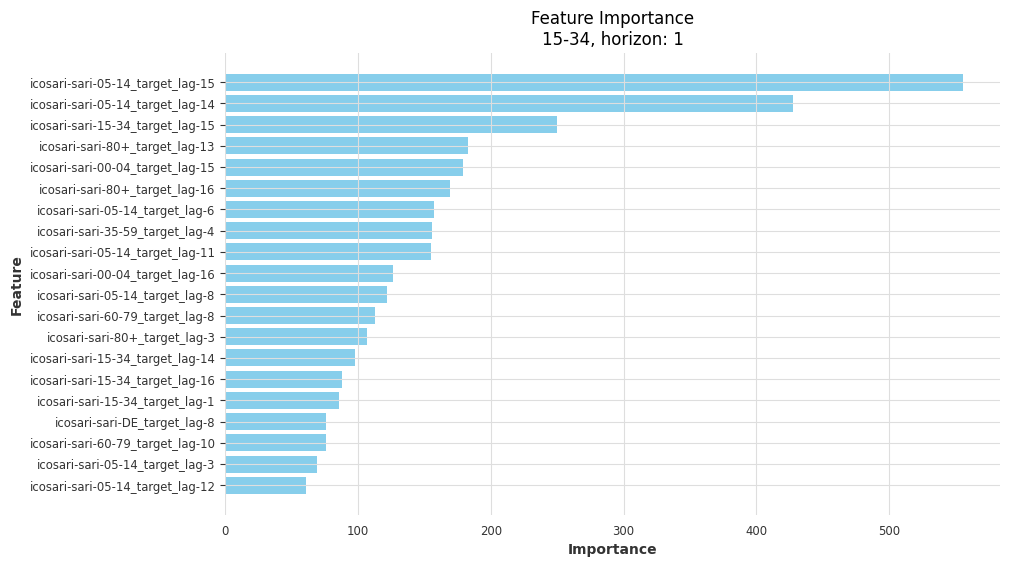

In [56]:
plot_importance_lgbm(model, age_group='15-34', horizon=1, max_features=20, y_size=6)

In [52]:
multiple_series, use_covariates, use_features, use_encoders

(True, False, True, True)

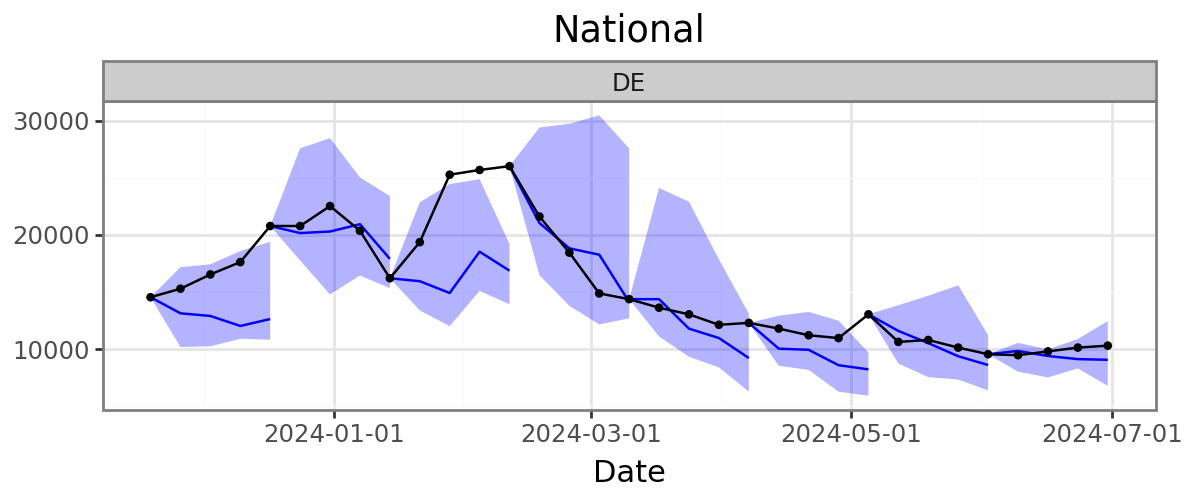

In [53]:
plot_forecasts(df_plot, 'national', start=1, stride=4)

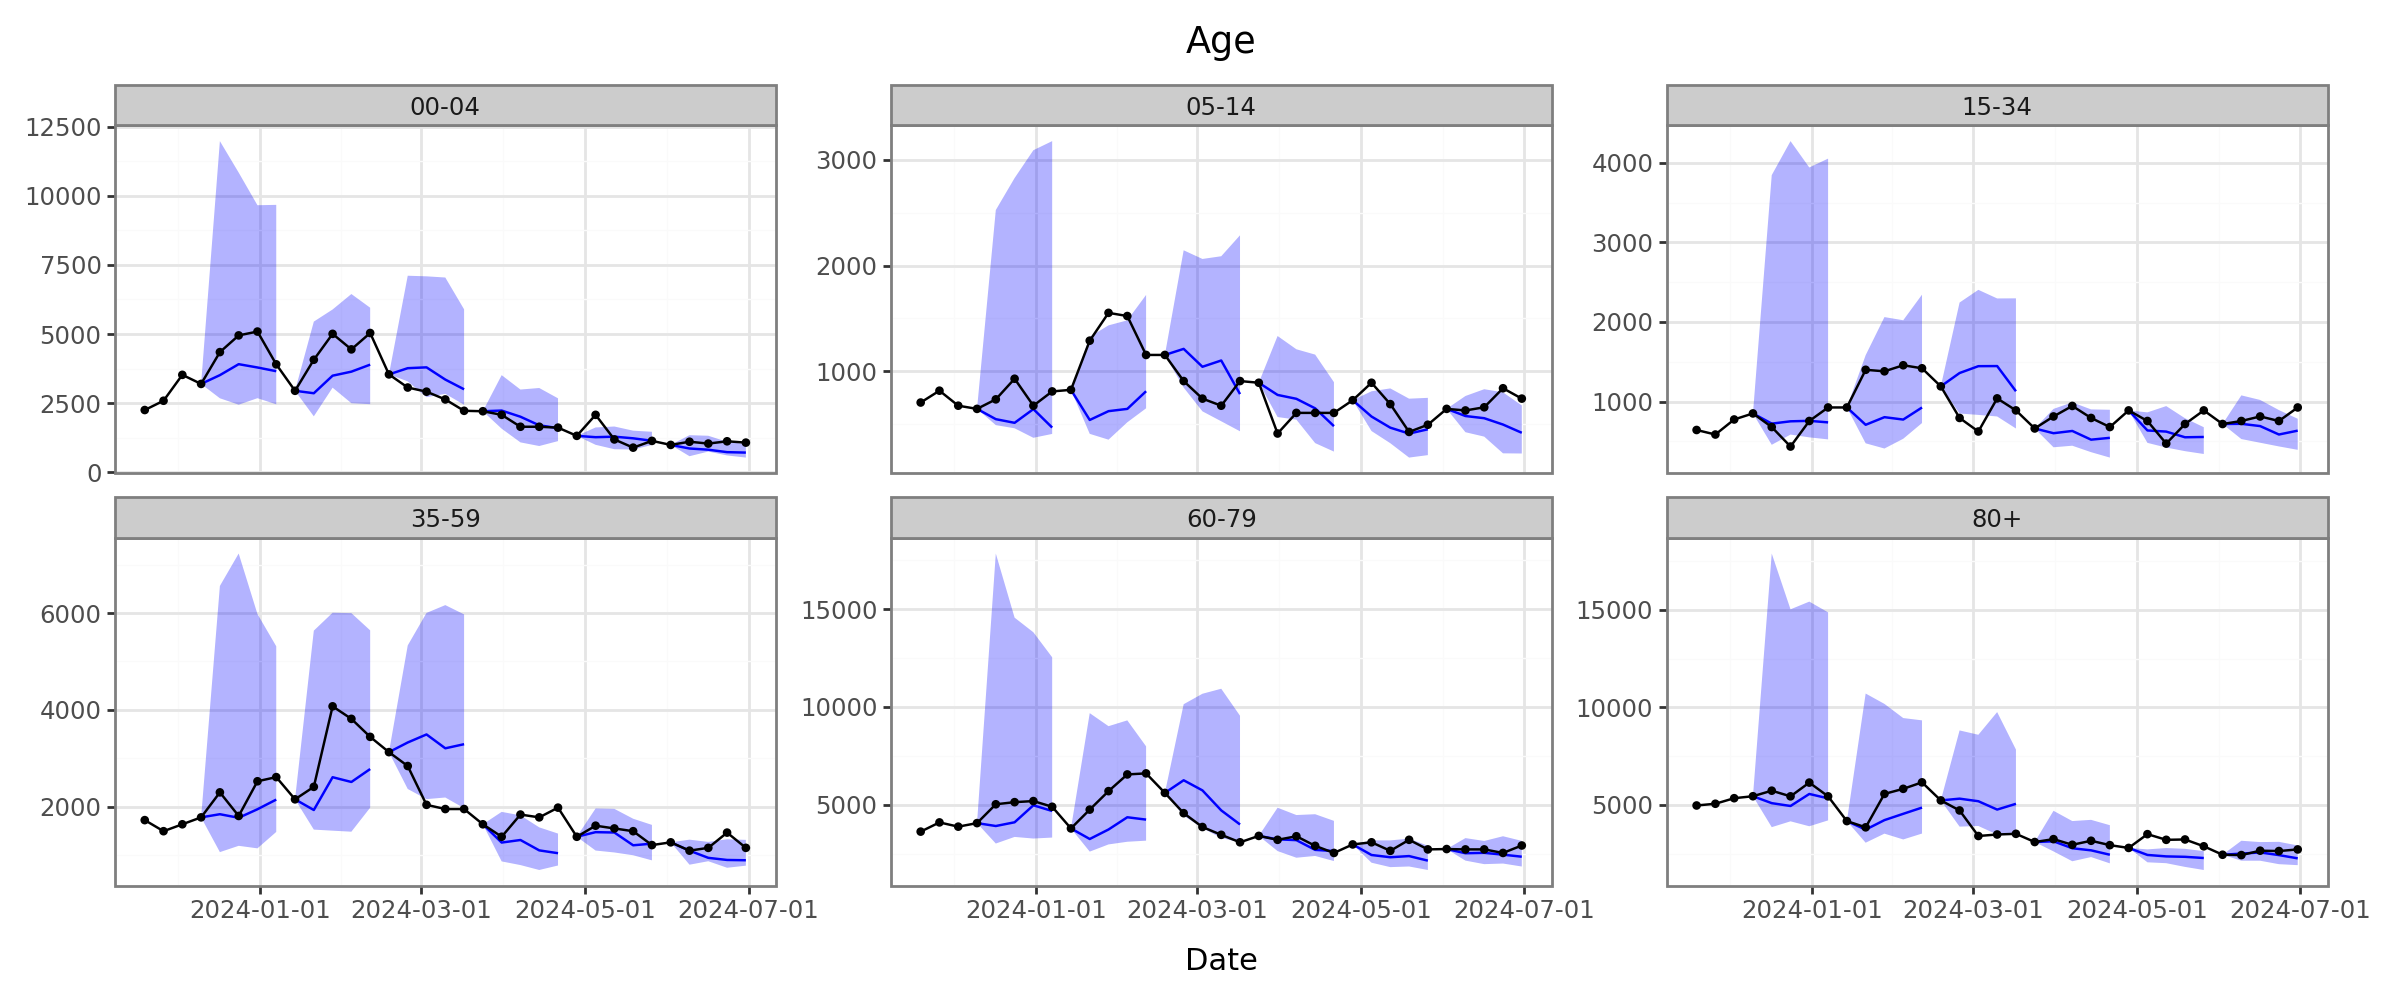

In [54]:
plot_forecasts(df_plot, 'age', start=4)

In [55]:
plot_importance_lgbm(model, age_group='15-34', horizon=1, max_features=20, y_size=6)

ValueError: 'icosari-sari-15-34_target_hrz0' is not in list

In [48]:
multiple_series, use_covariates, use_features, use_encoders

(False, True, False, True)

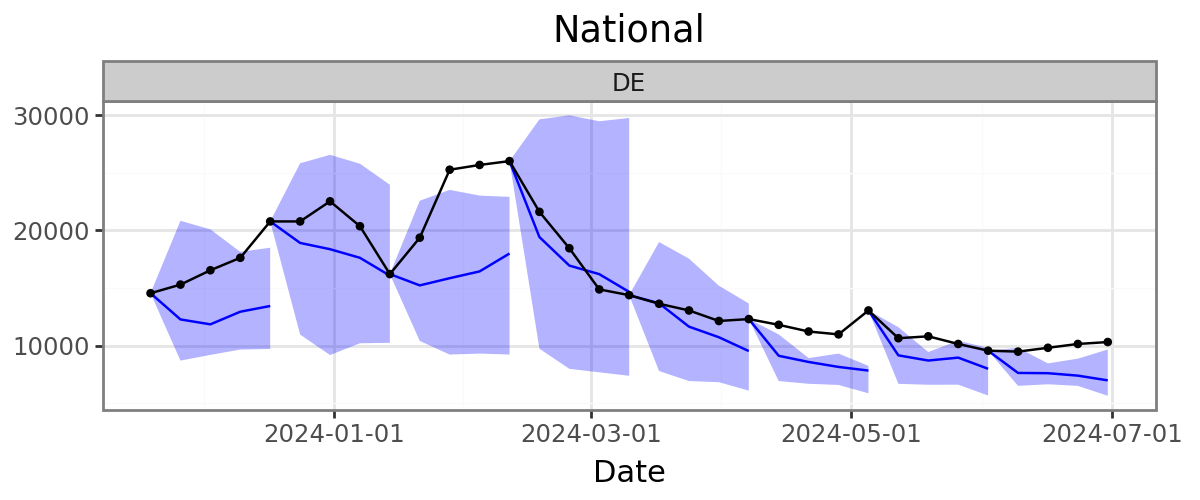

In [41]:
plot_forecasts(df_plot, 'national', start=1, stride=4)

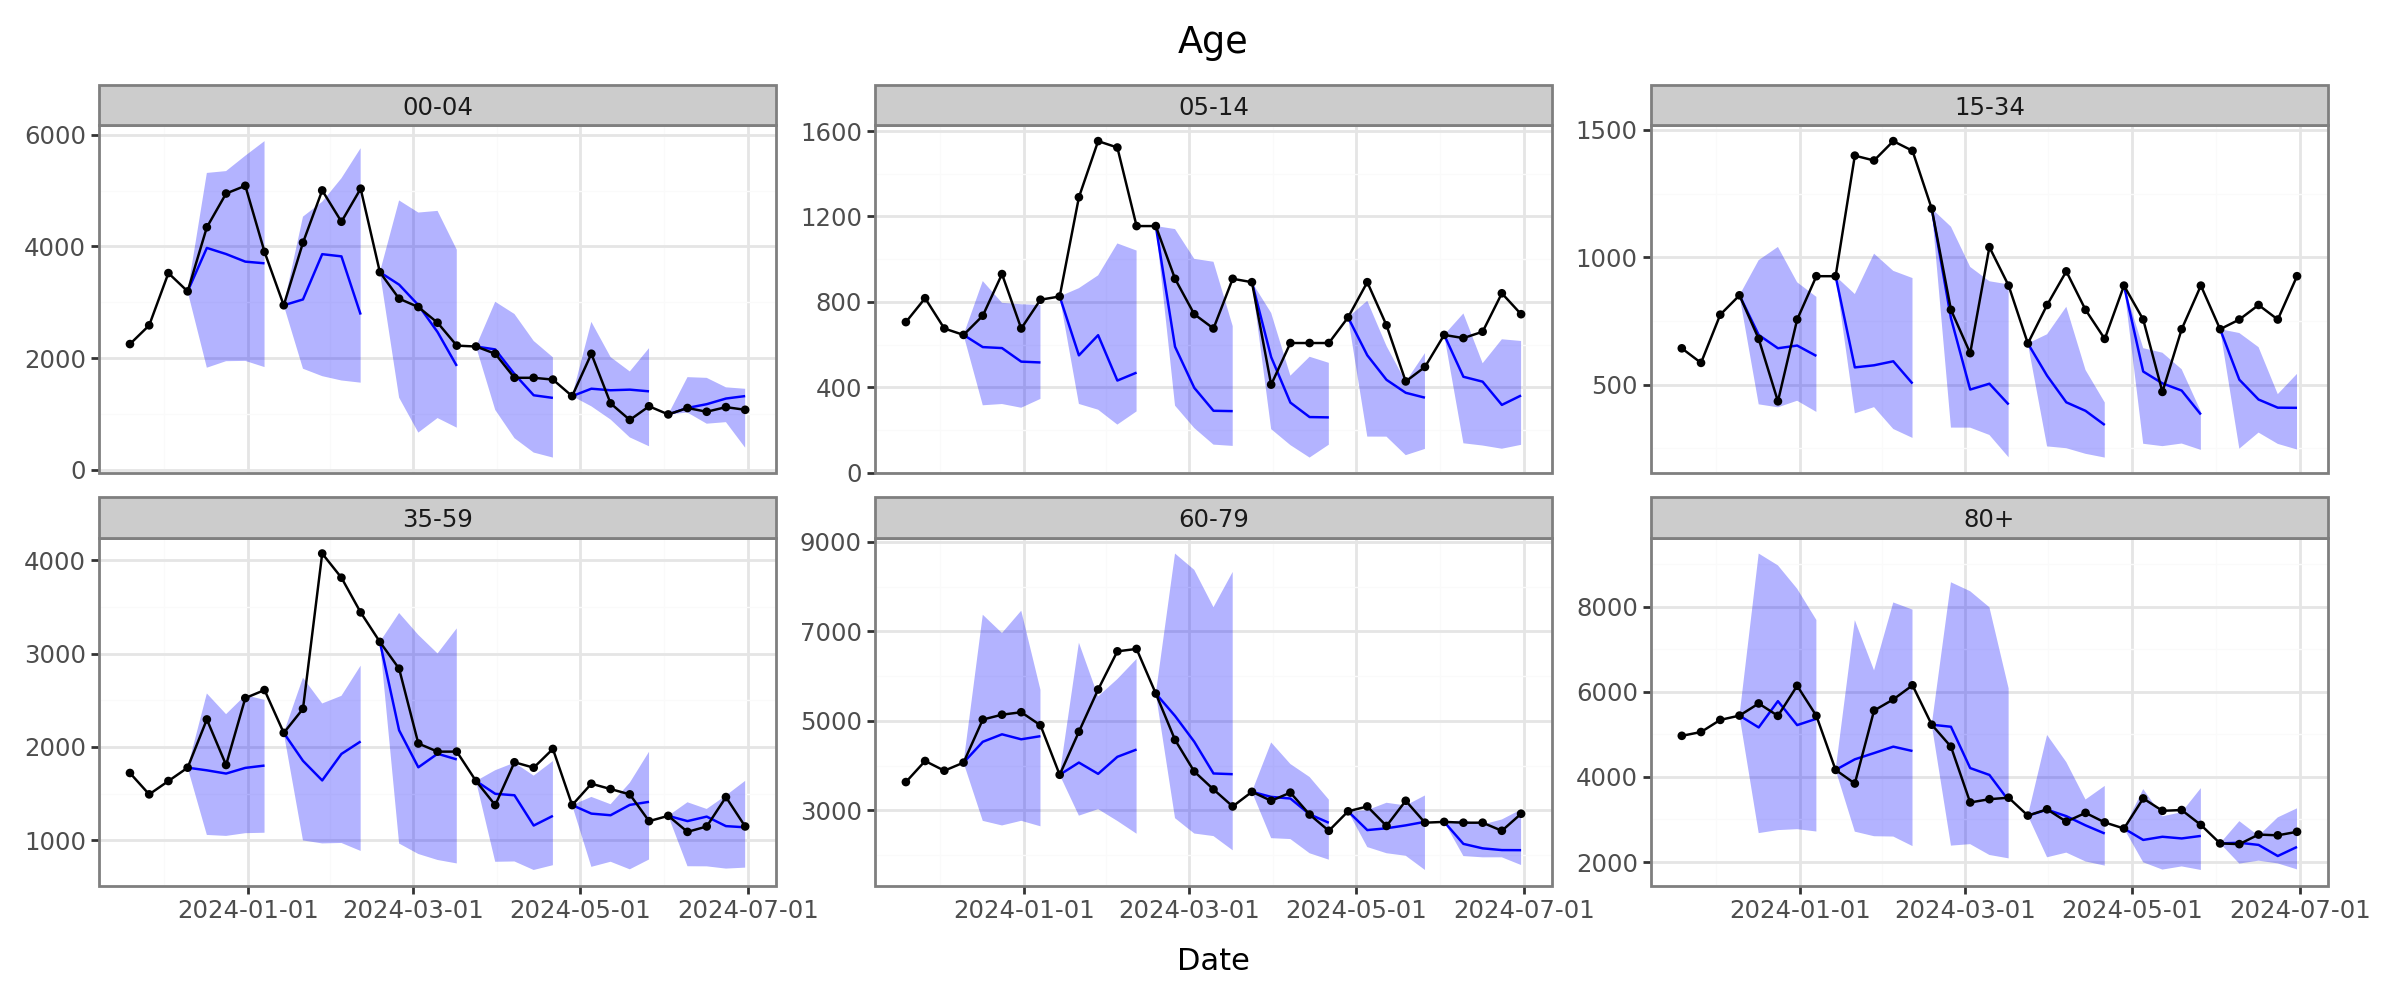

In [42]:
plot_forecasts(df_plot, 'age', start=4)

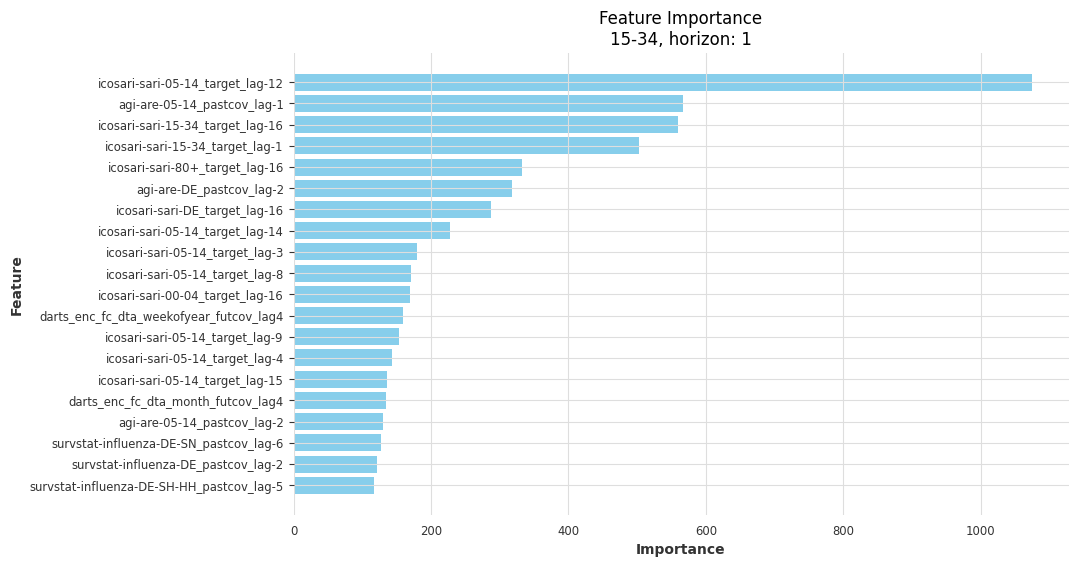

In [46]:
plot_importance_lgbm(model, age_group='15-34', horizon=1, max_features=20, y_size=6)

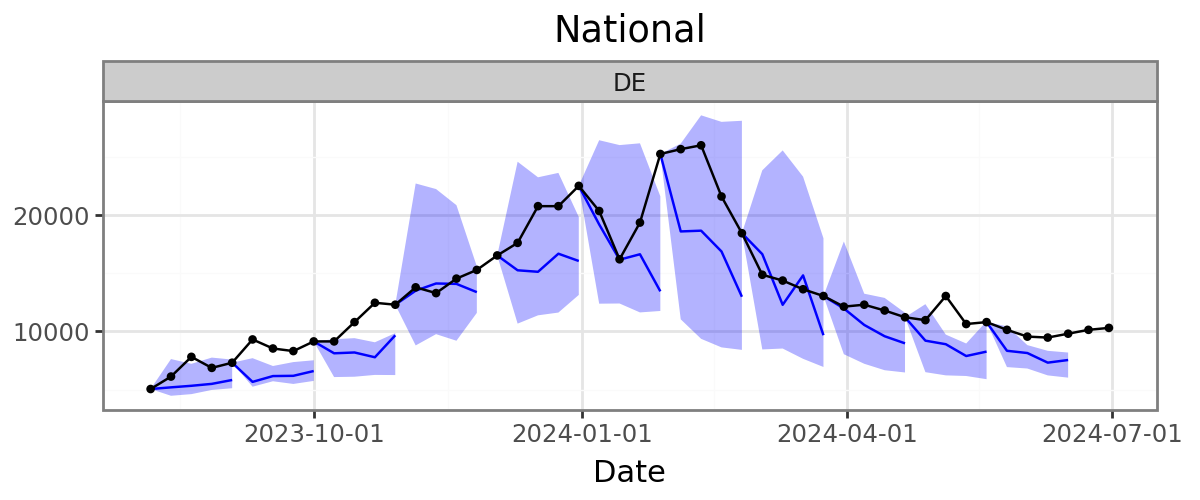

In [100]:
# global, all features and covariates
plot_forecasts(df_plot, 'national', start=1, stride=4)

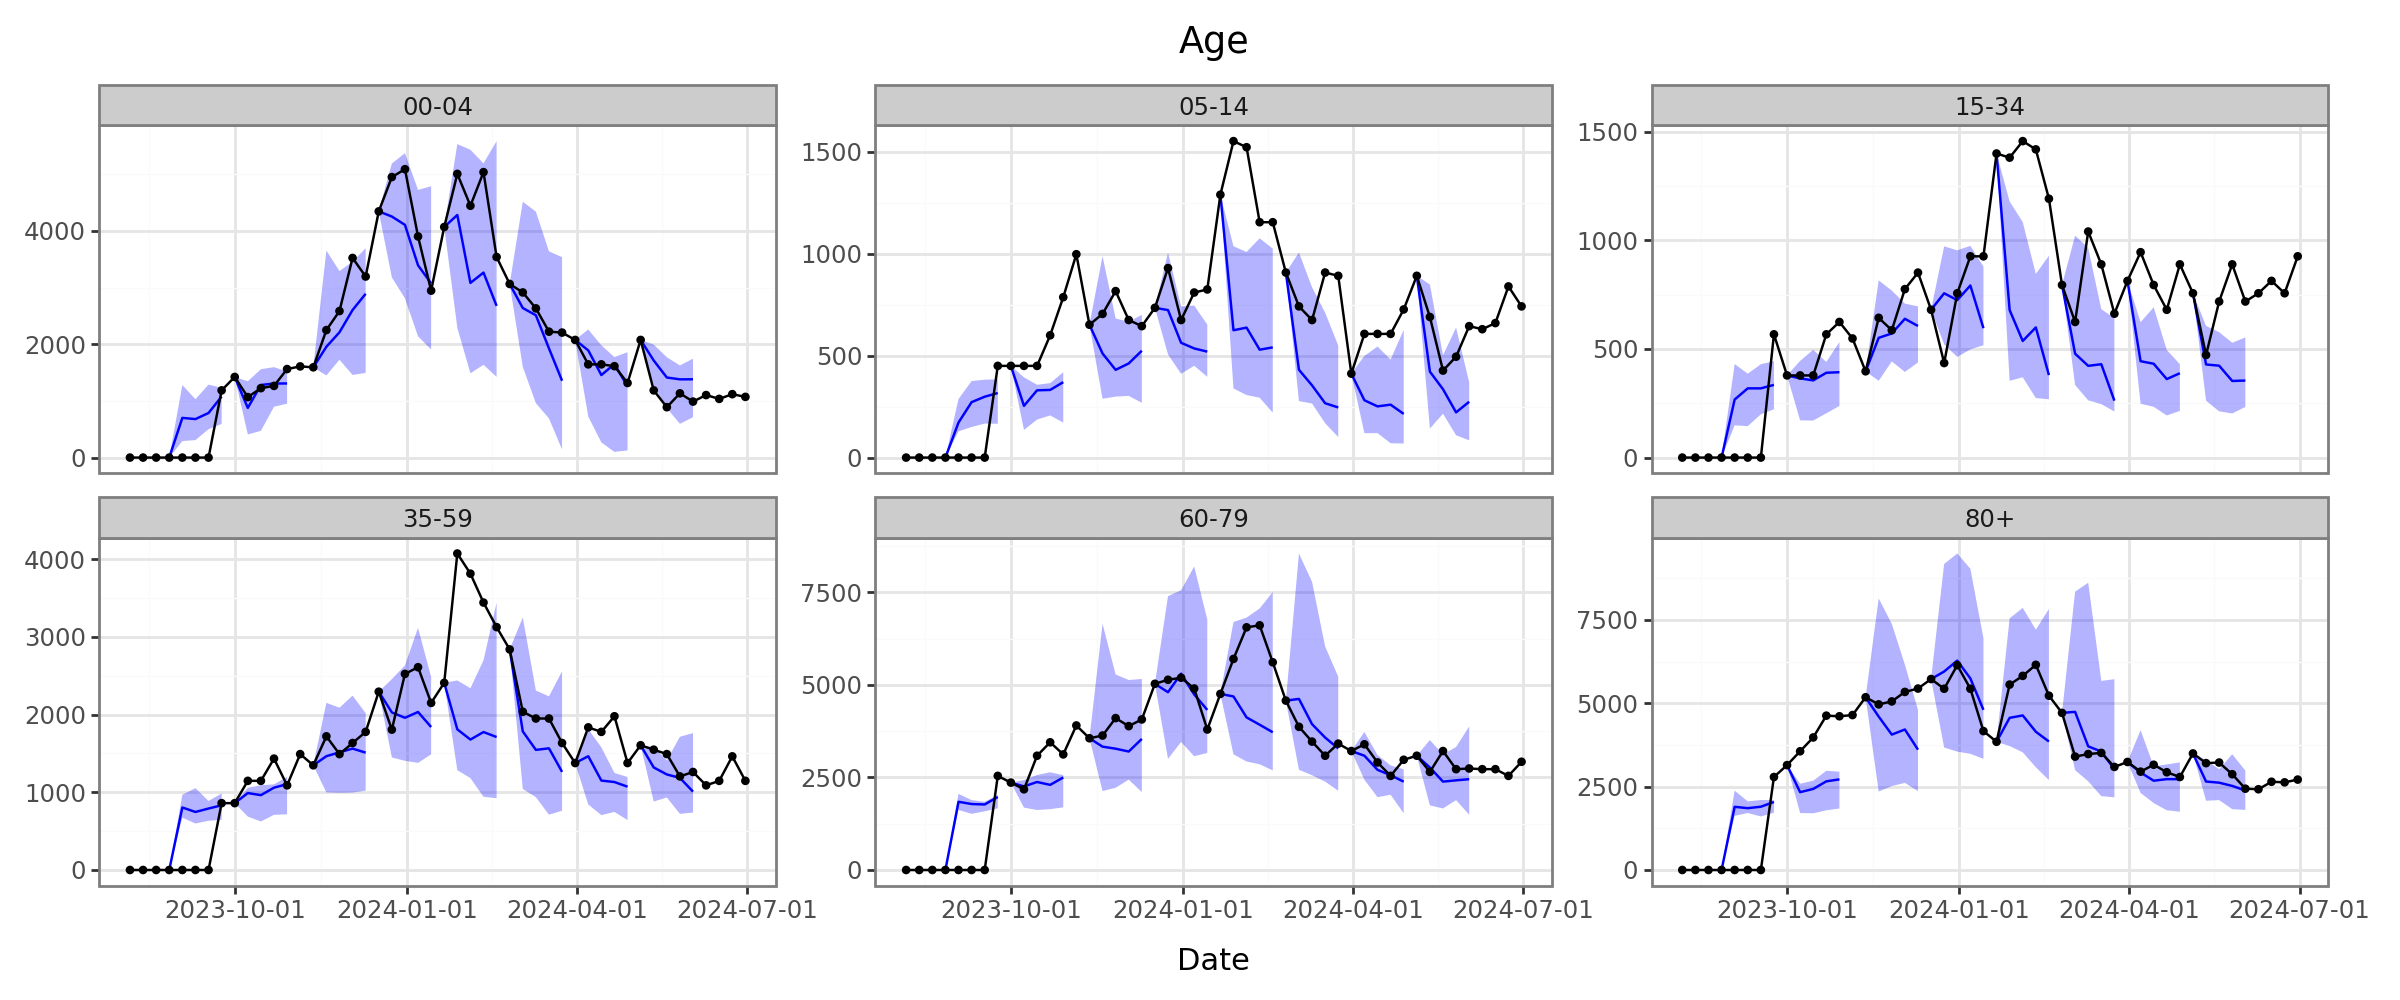

In [91]:
plot_forecasts(df_plot, 'age', start=4)

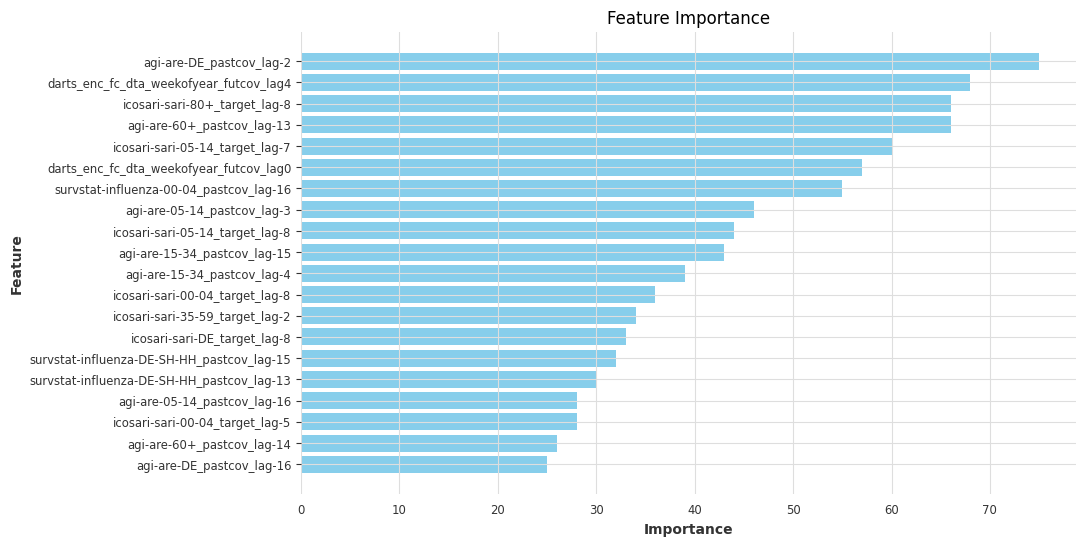

In [93]:
plot_importance_lgbm(model, horizon=0, max_features=20, y_size=6)

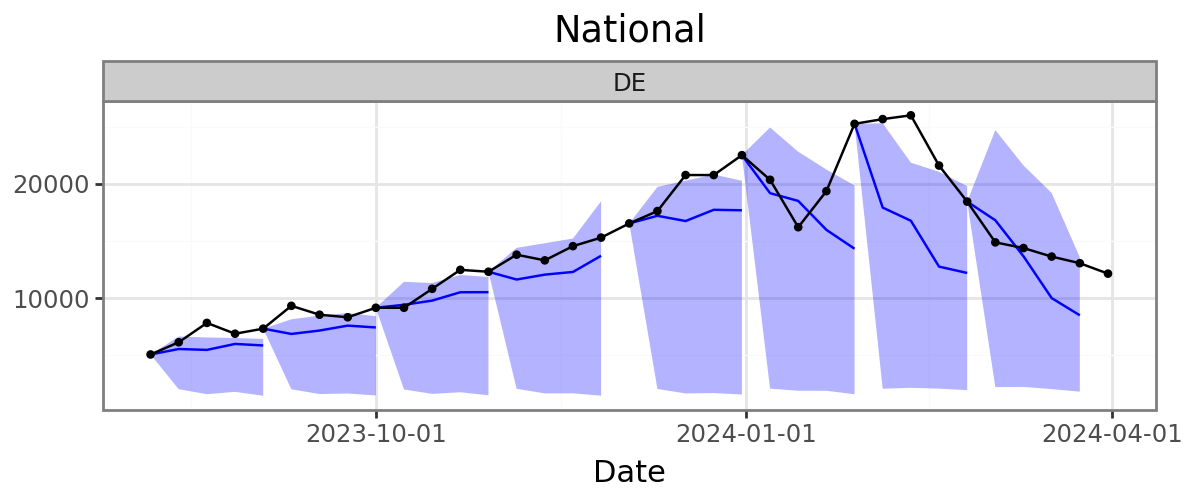

In [83]:
# global, all features and covariates
plot_forecasts(df_plot, 'national', start=1, stride=4)

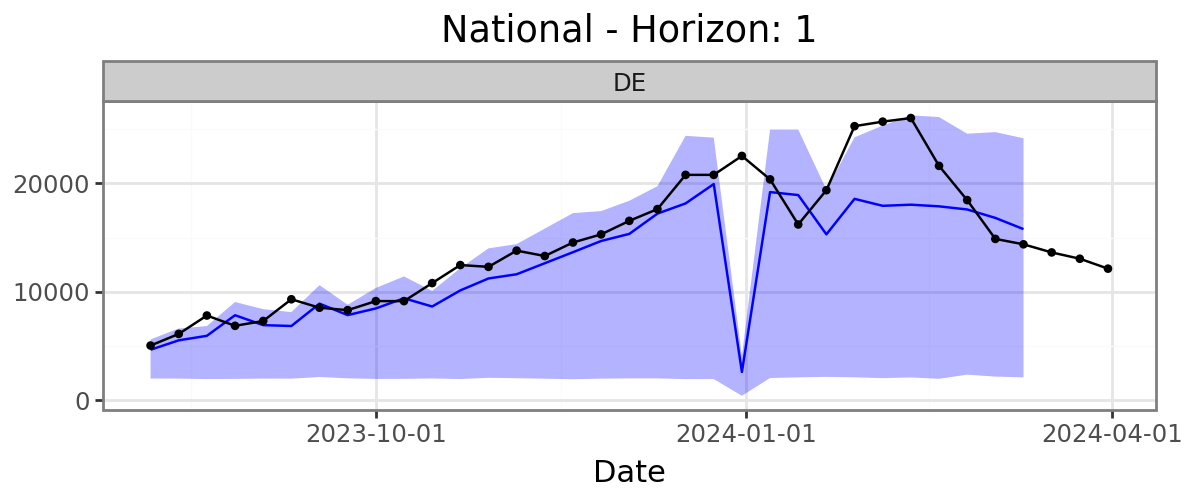

In [84]:
plot_forecasts(df_plot, 'national', horizon=1)

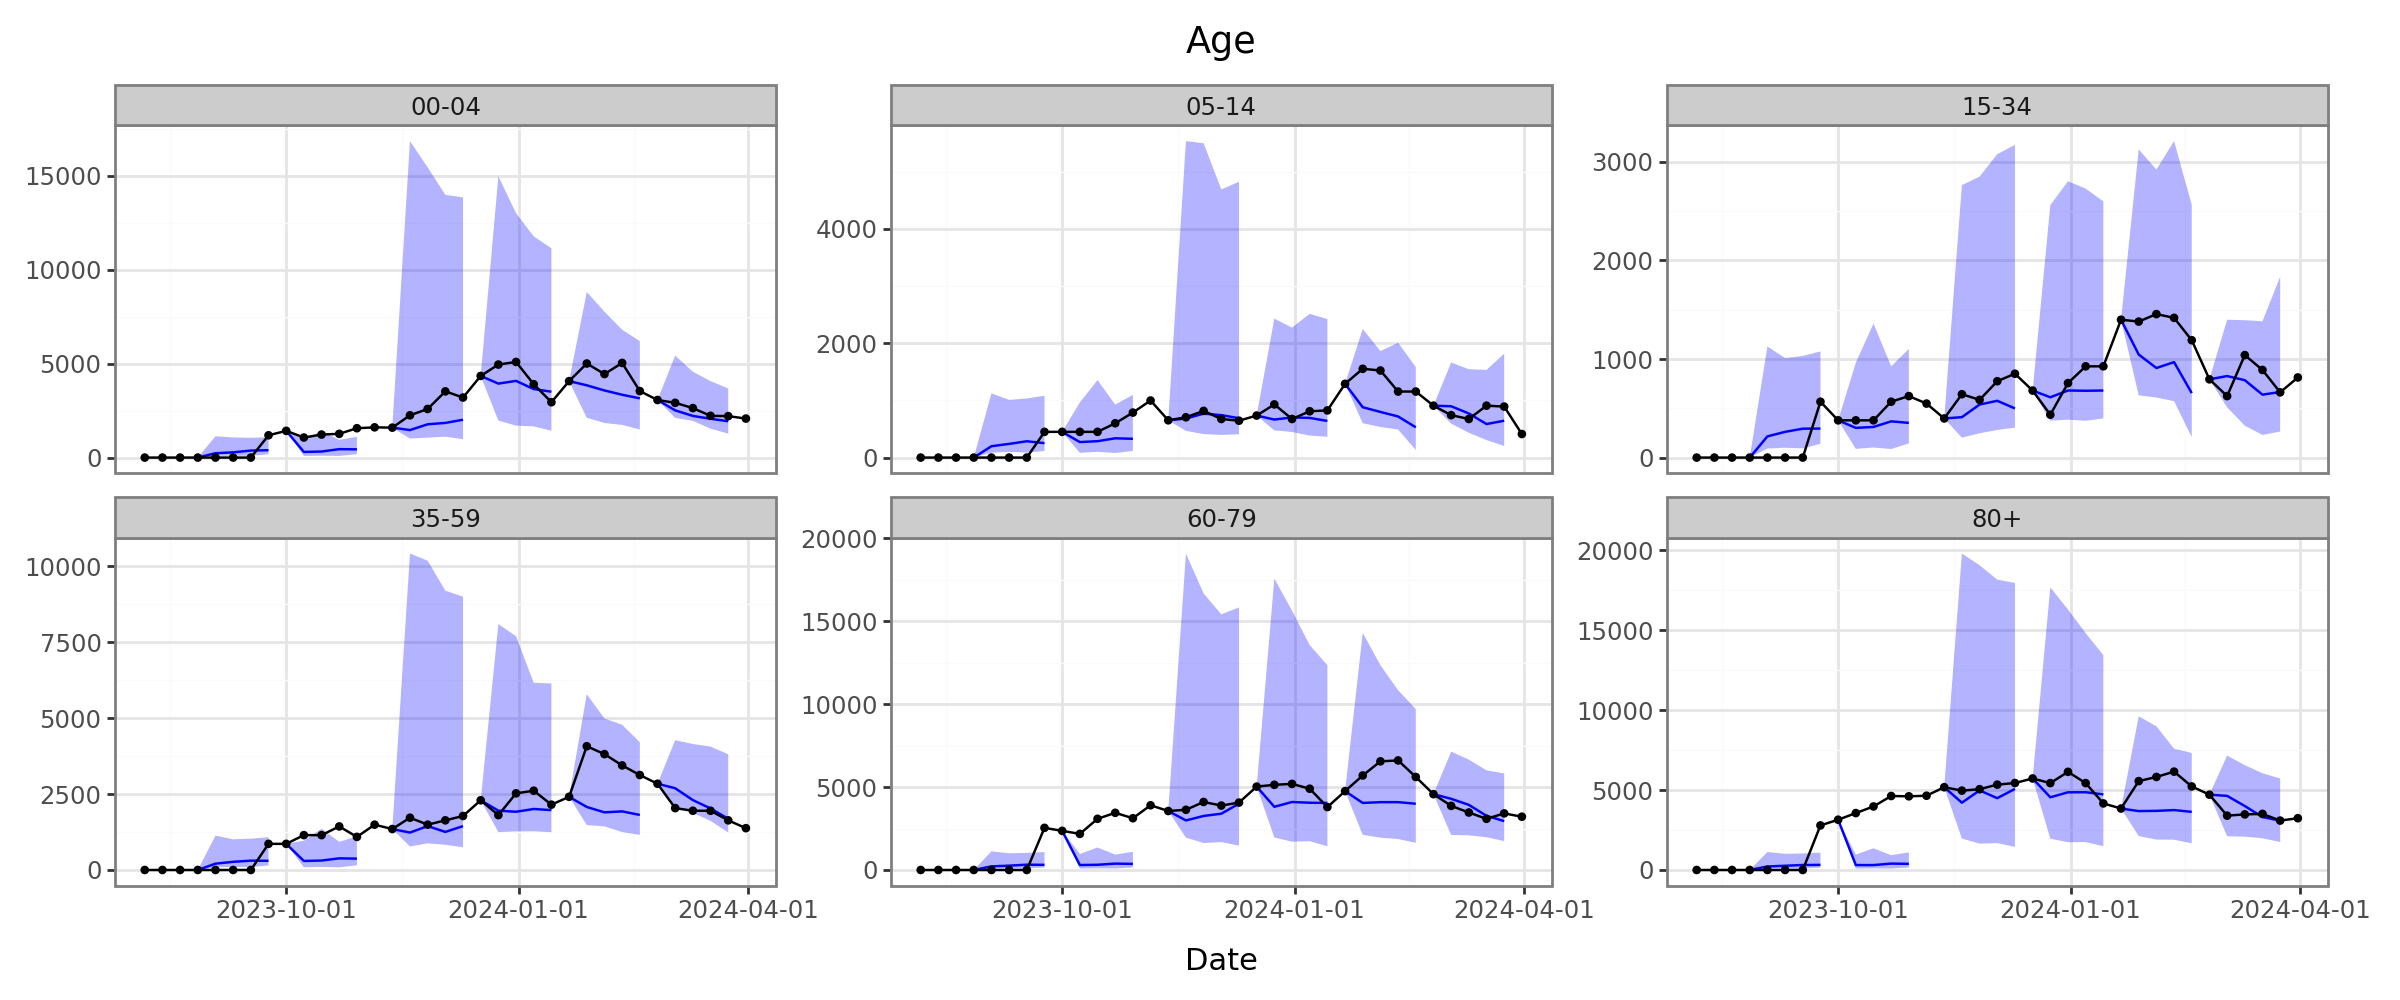

In [85]:
plot_forecasts(df_plot, 'age', start=4)

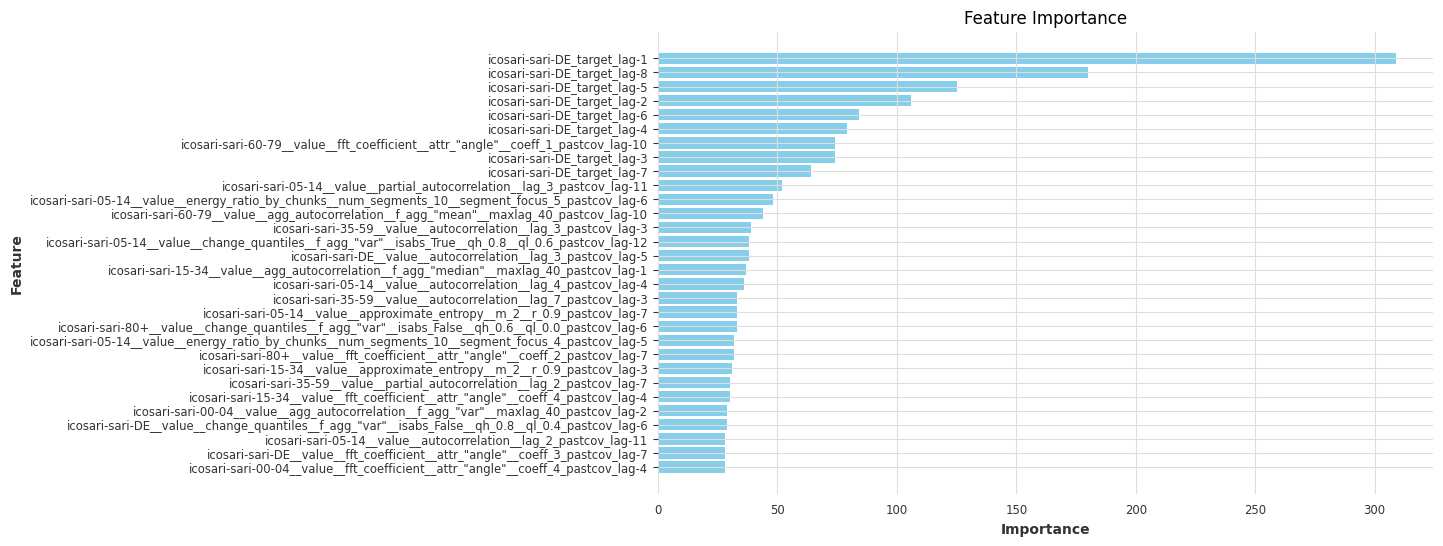

In [88]:
plot_importance_lgbm(model, horizon=0, max_features=30, y_size=6)

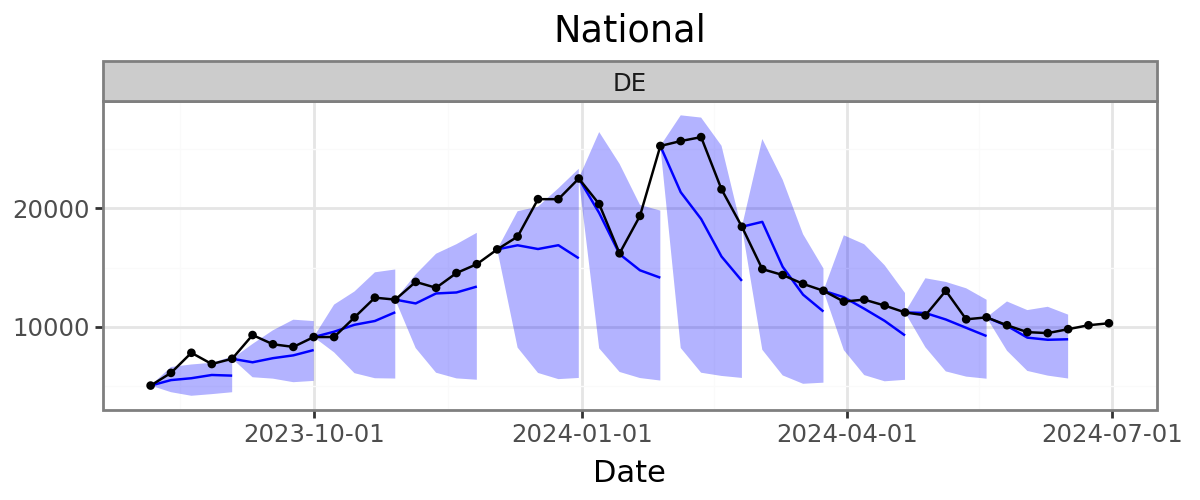

In [40]:
plot_forecasts(df_plot, 'national', start=1, stride=4)

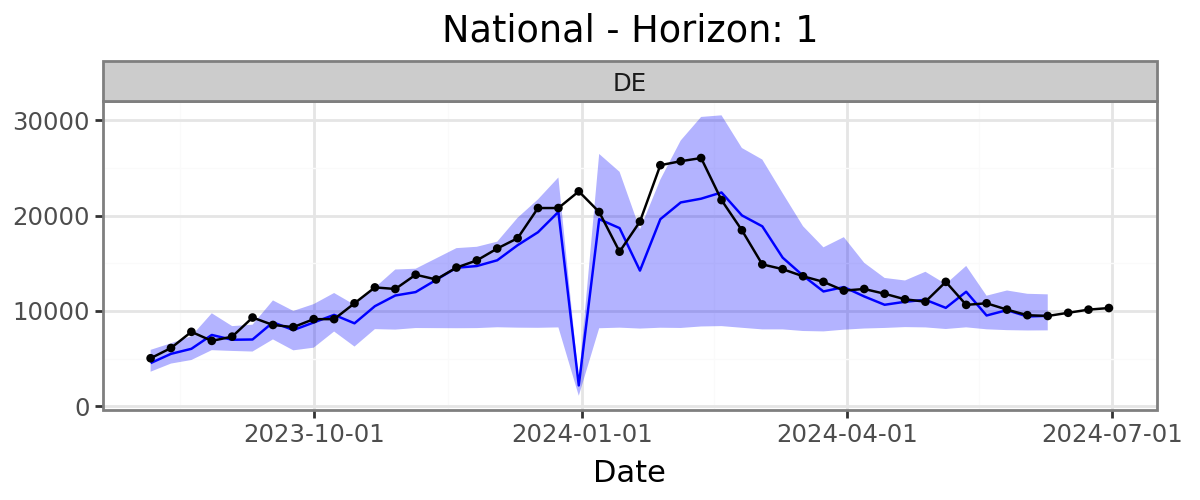

In [41]:
plot_forecasts(df_plot, 'national', horizon=1)

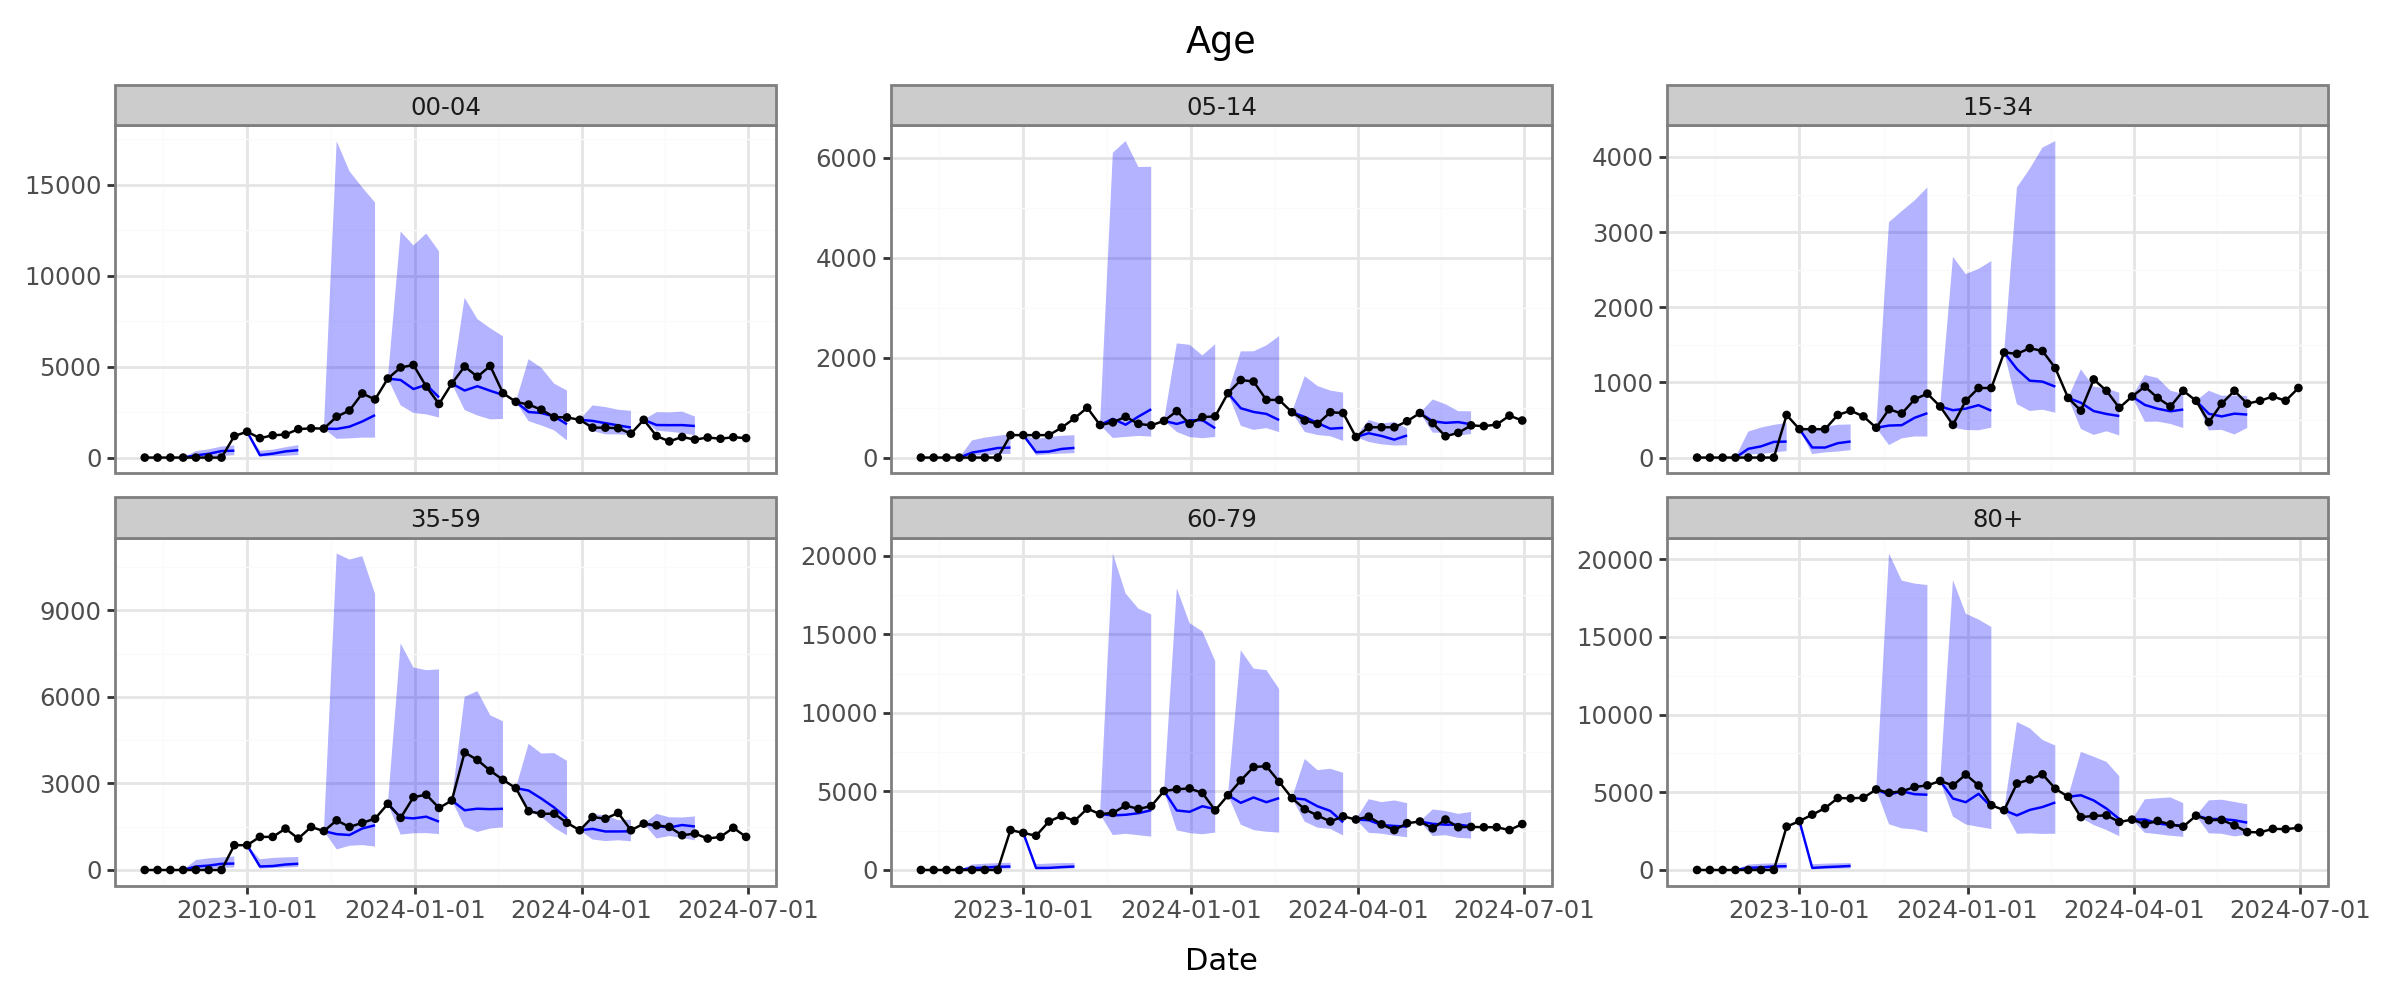

In [42]:
plot_forecasts(df_plot, 'age', start=4)

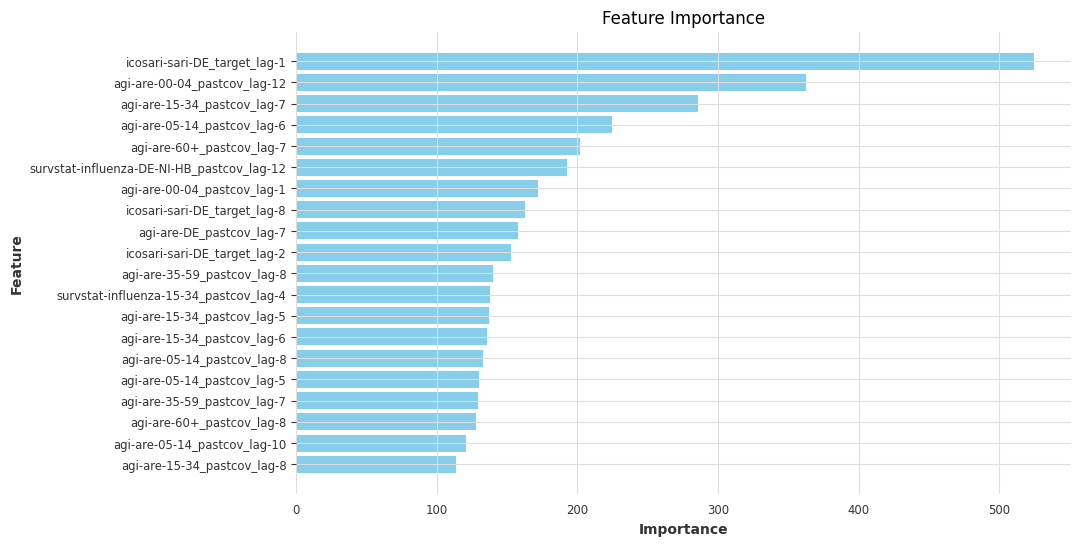

In [43]:
plot_importance_lgbm(model, horizon=1, max_features=20, y_size=6)

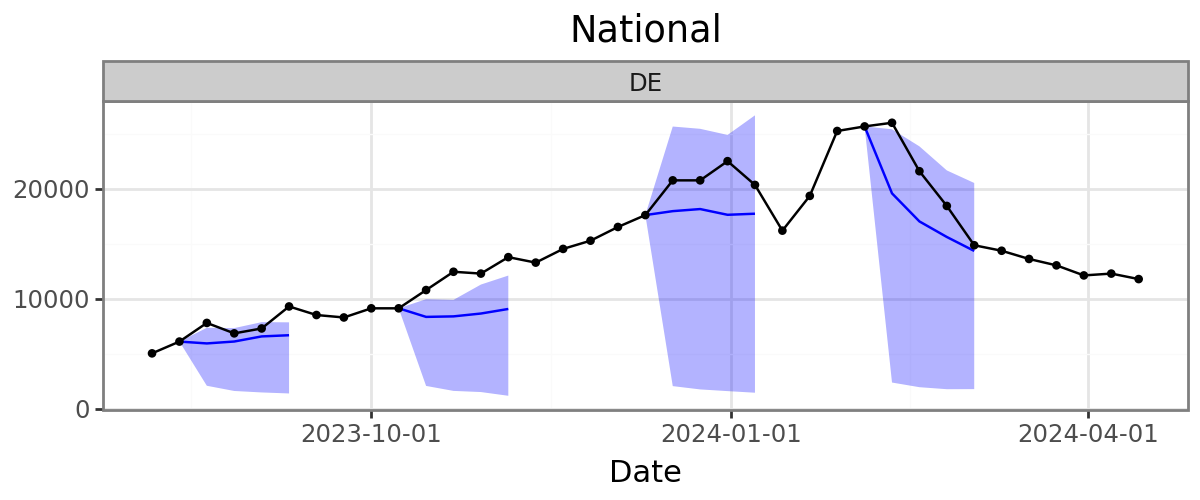

In [82]:
plot_forecasts(df_plot, 'national', start=1, stride=4)

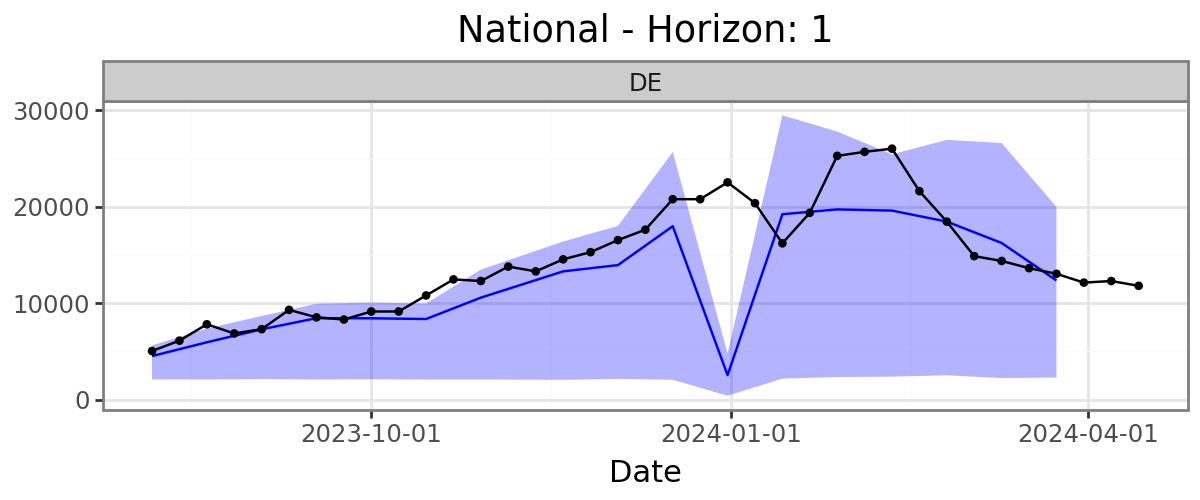

In [83]:
plot_forecasts(df_plot, 'national', horizon=1)

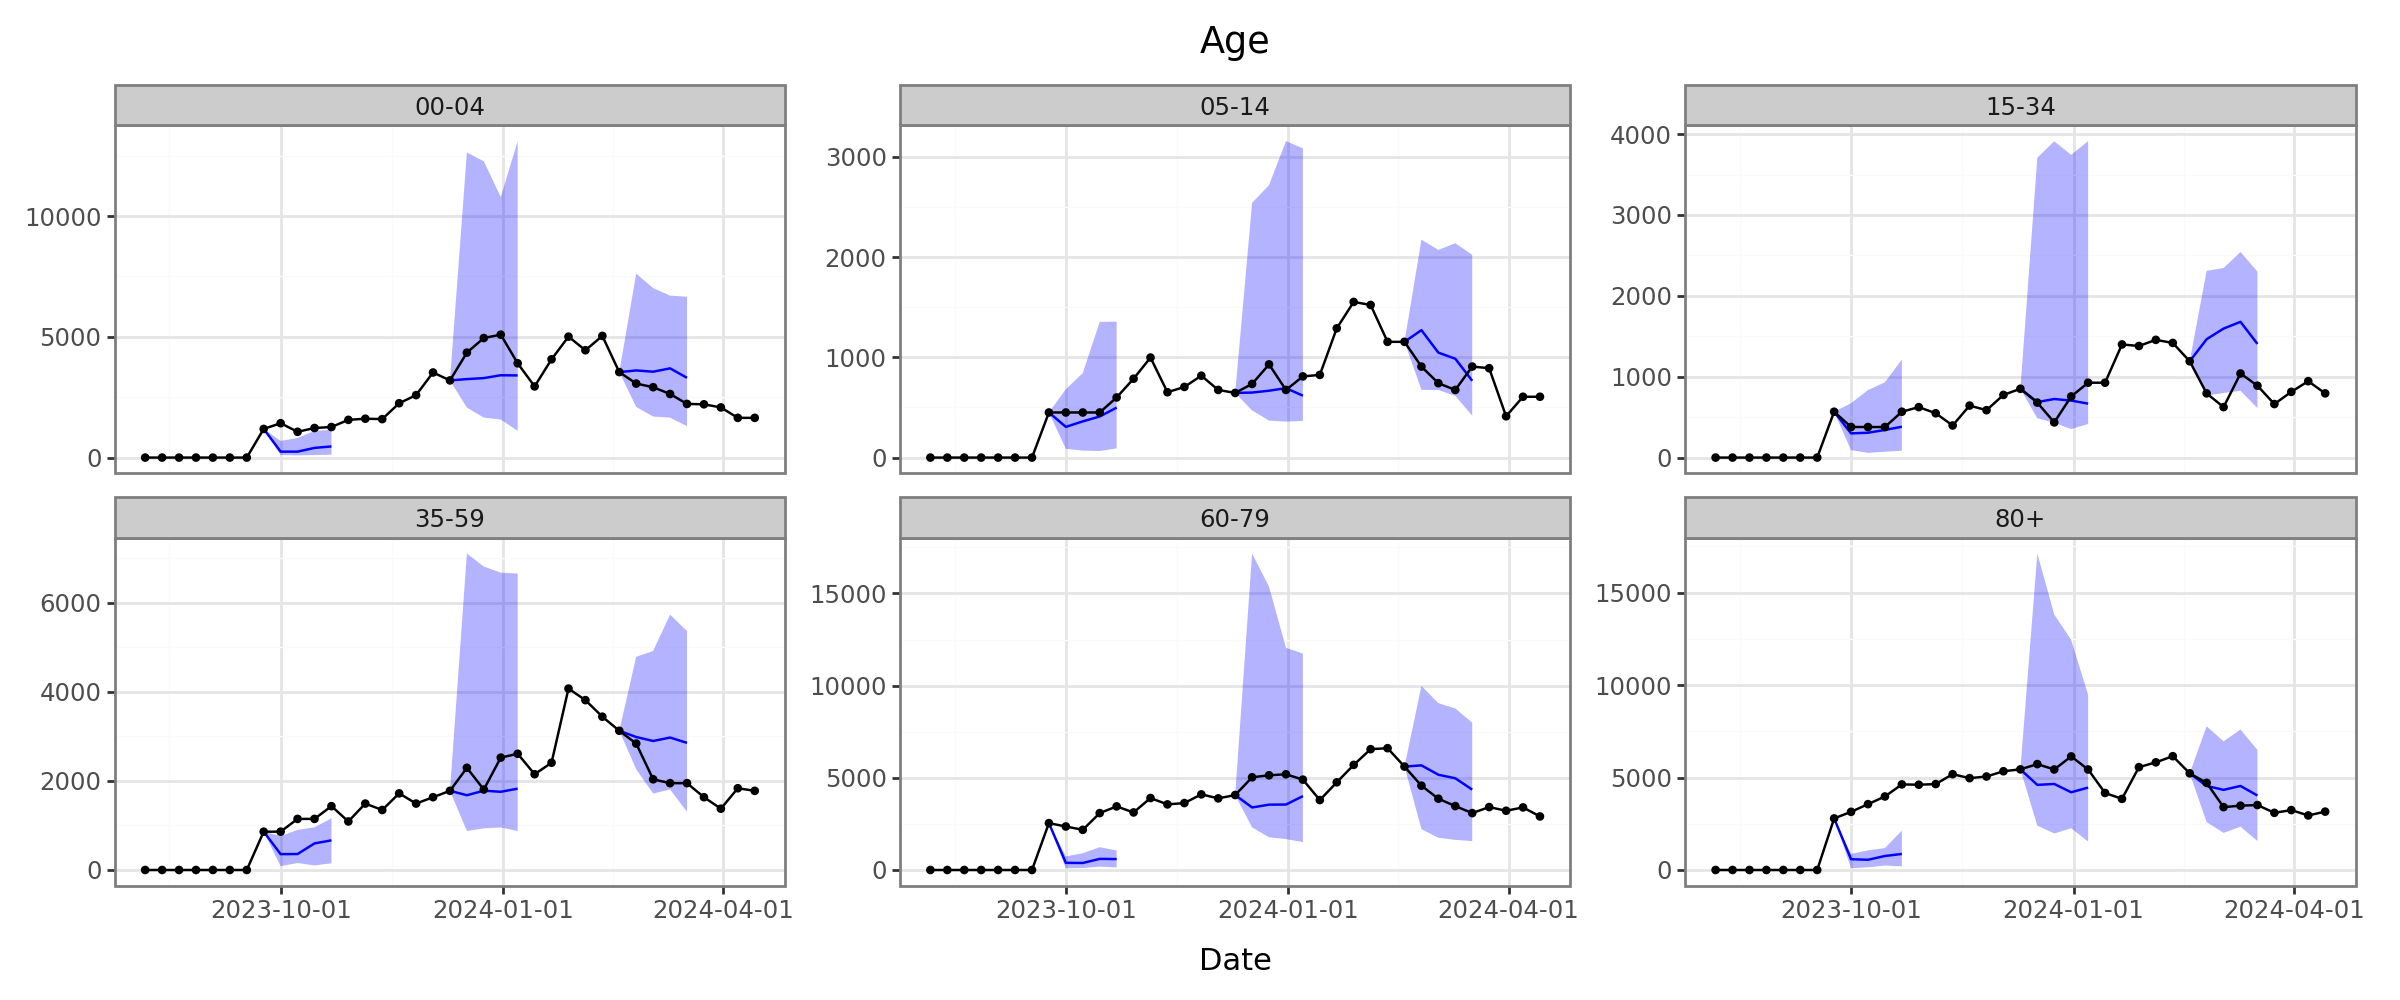

In [84]:
plot_forecasts(df_plot, 'age', start=4)

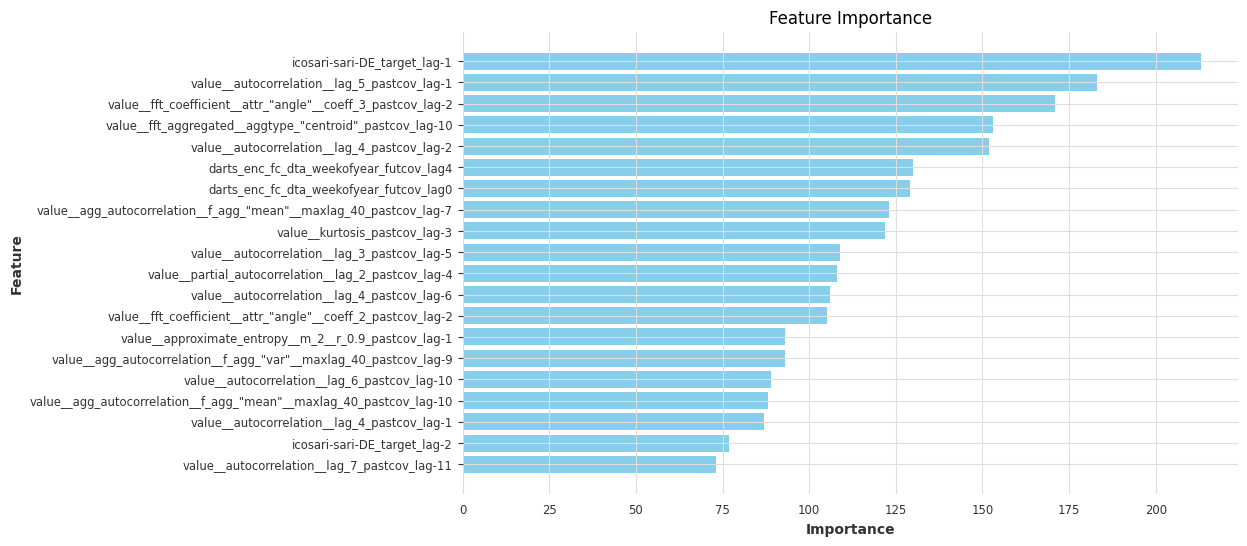

In [88]:
plot_importance_lgbm(model, horizon=1, max_features=20, y_size=6)

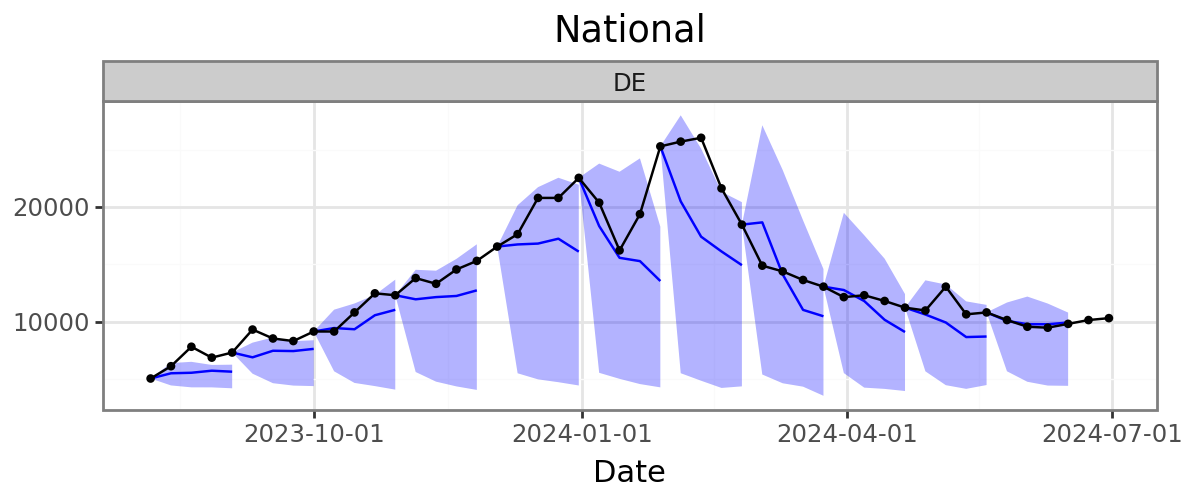

In [36]:
plot_forecasts(df_plot, 'national', start=1, stride=4)

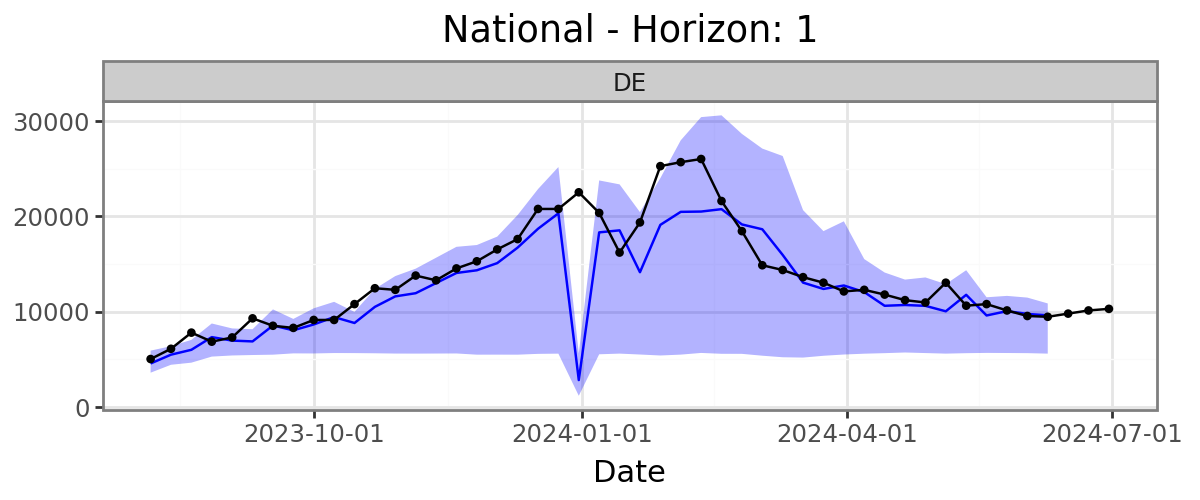

In [37]:
plot_forecasts(df_plot, 'national', horizon=1)

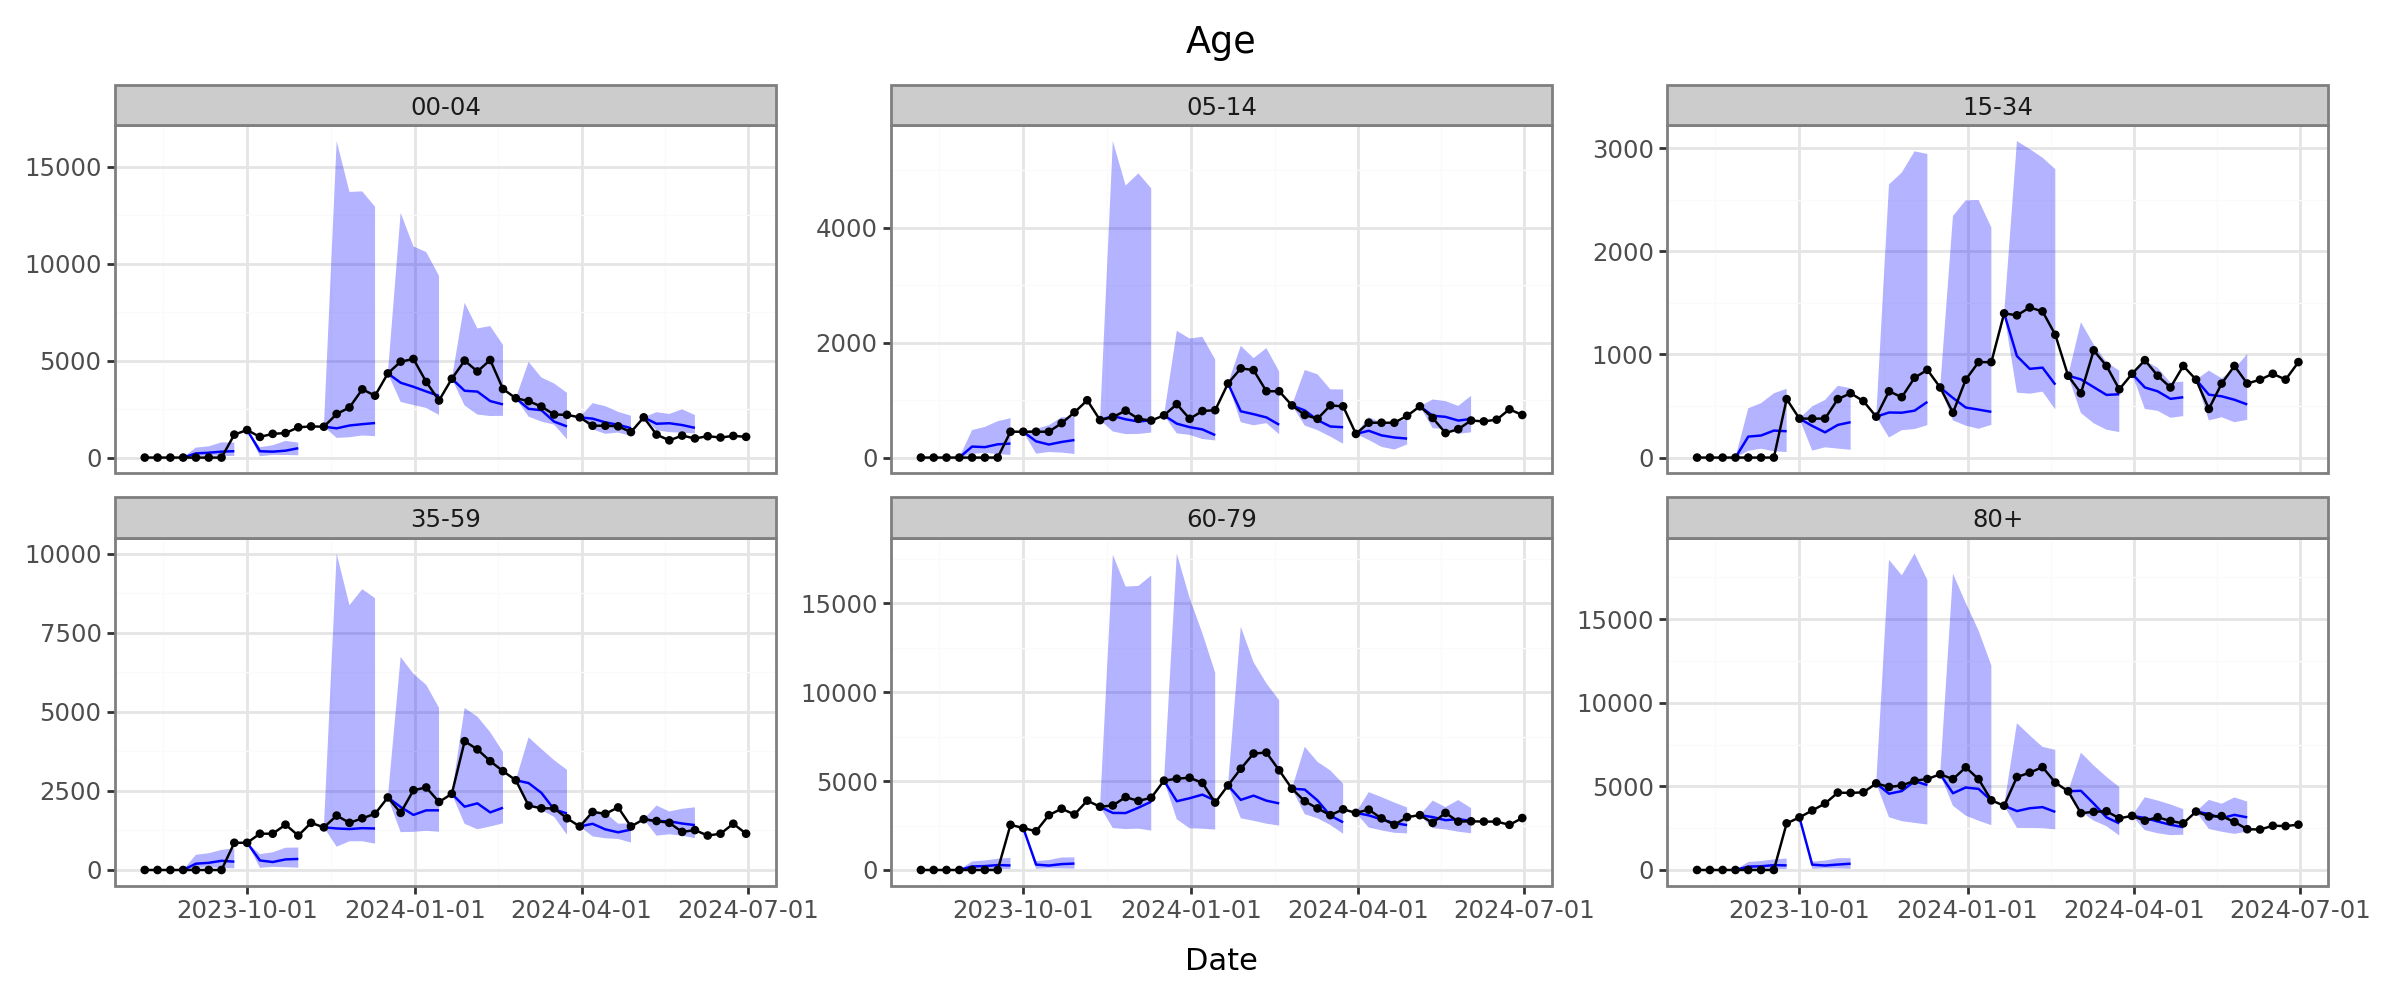

In [41]:
plot_forecasts(df_plot, 'age', start=4)

## OLD

### Multivariate, covariates, lag 8, no encoders

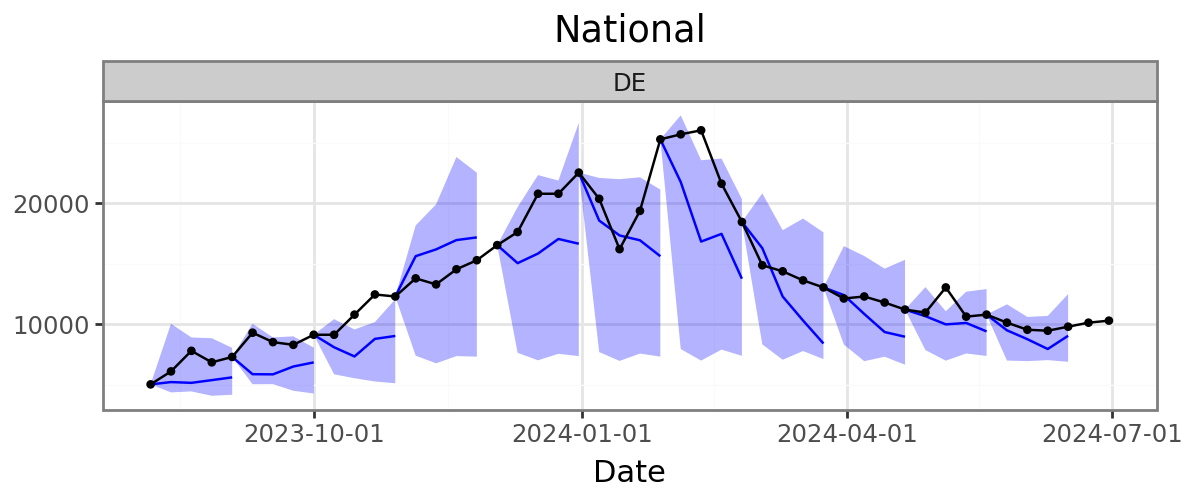

In [101]:
plot_forecasts(df_plot, 'national', start=1, stride=4)

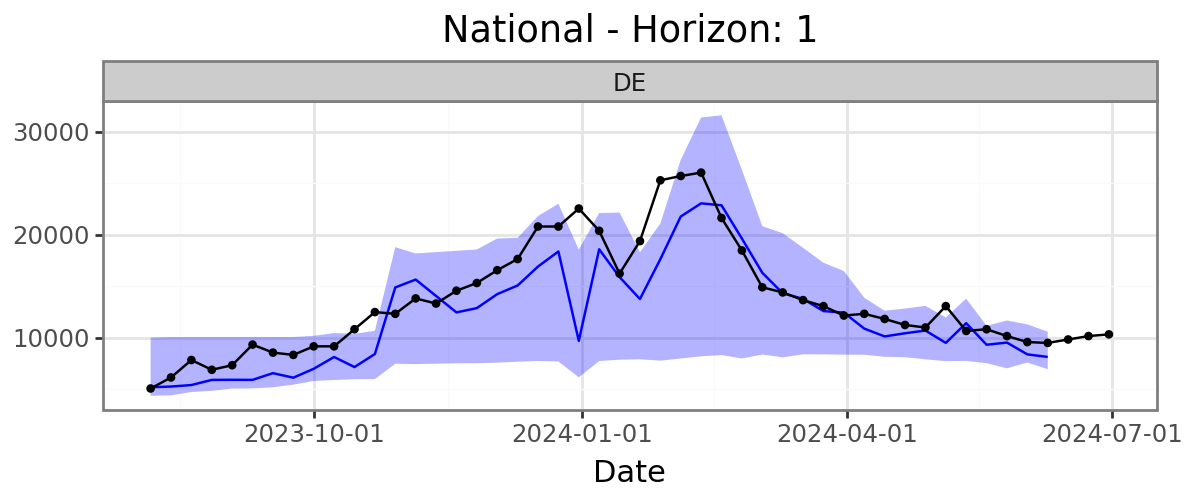

In [102]:
plot_forecasts(df_plot, 'national', horizon=1)

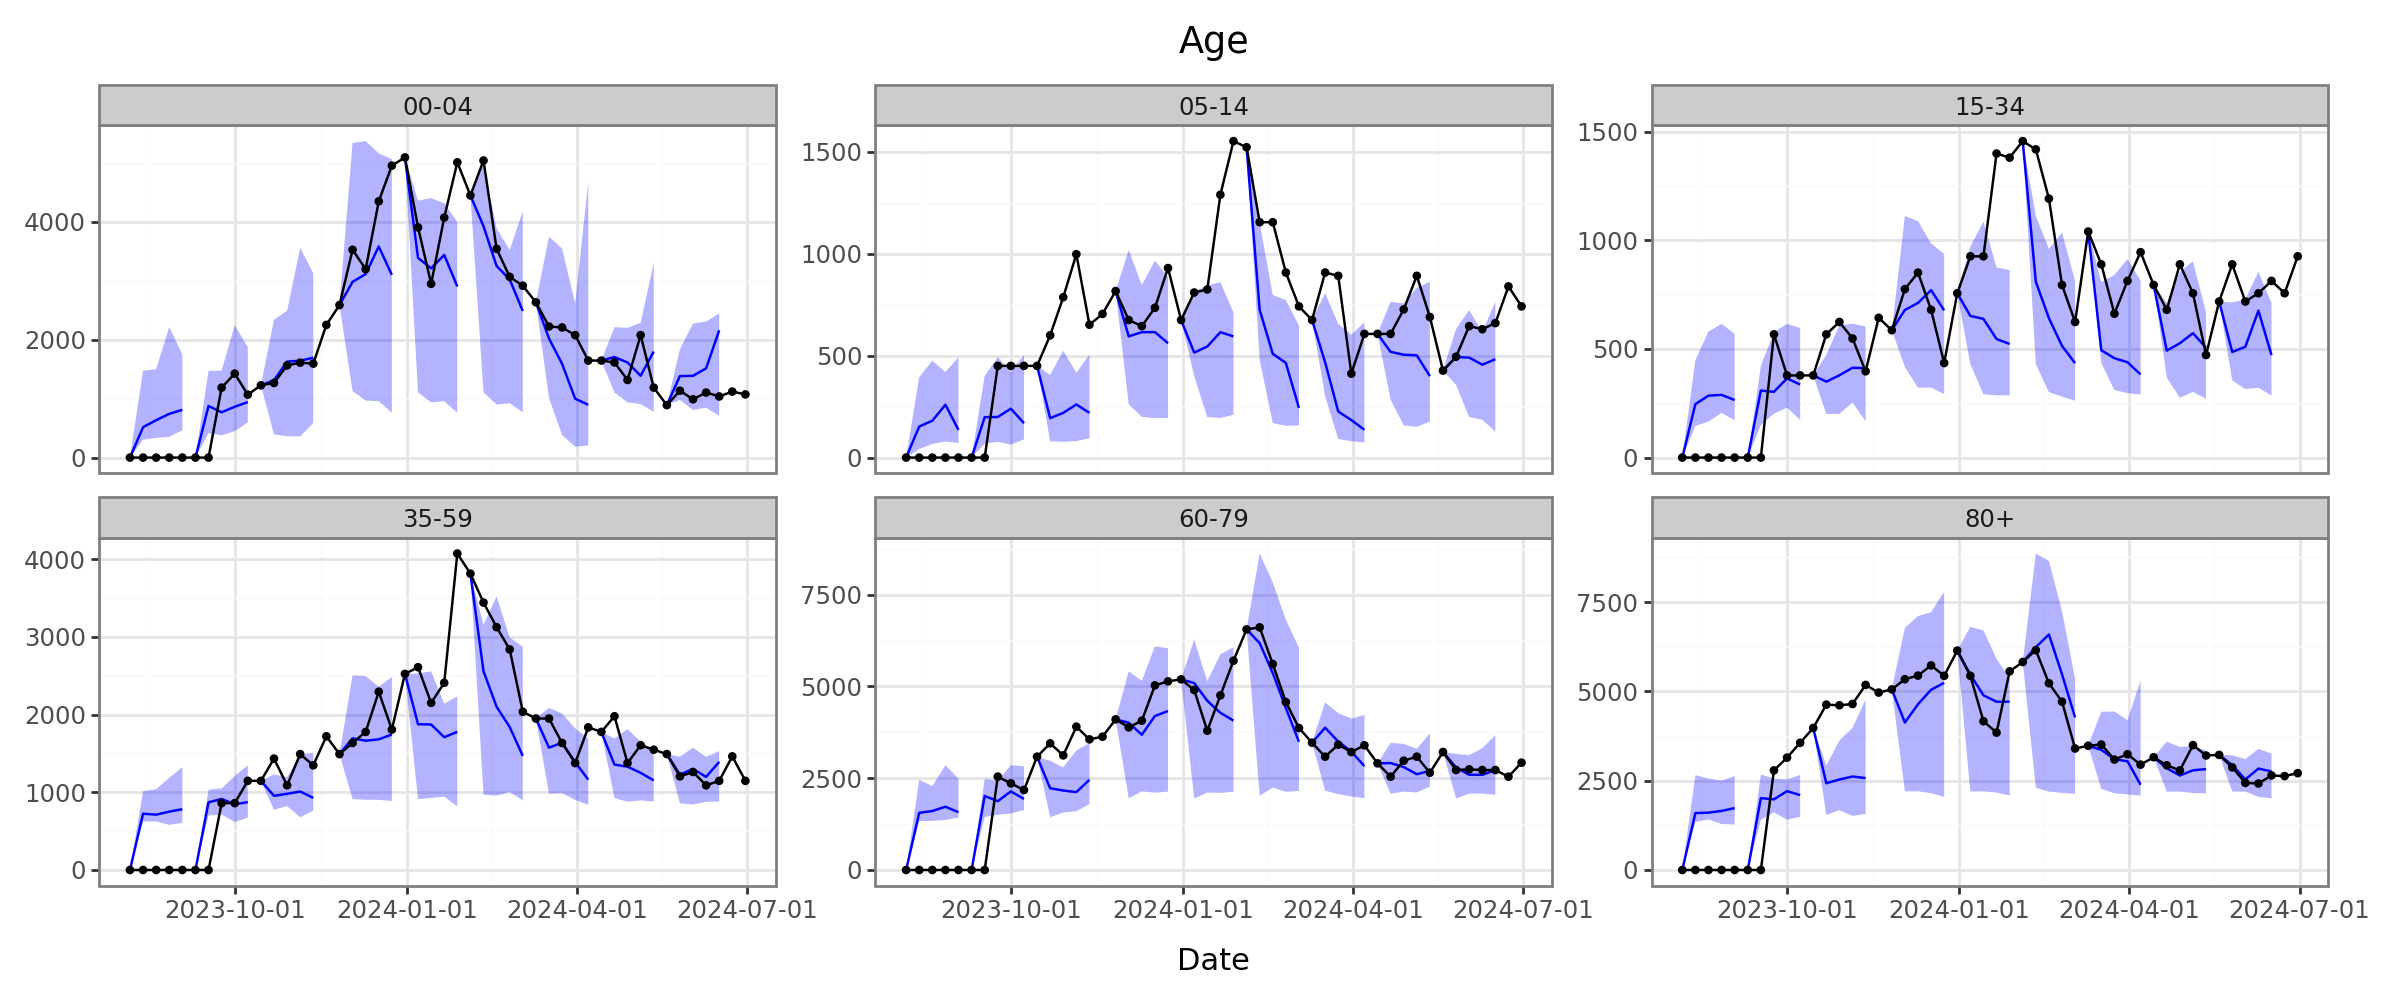

In [103]:
plot_forecasts(df_plot, 'age', start=1)

### Global, covariates, lag 8, no encoders

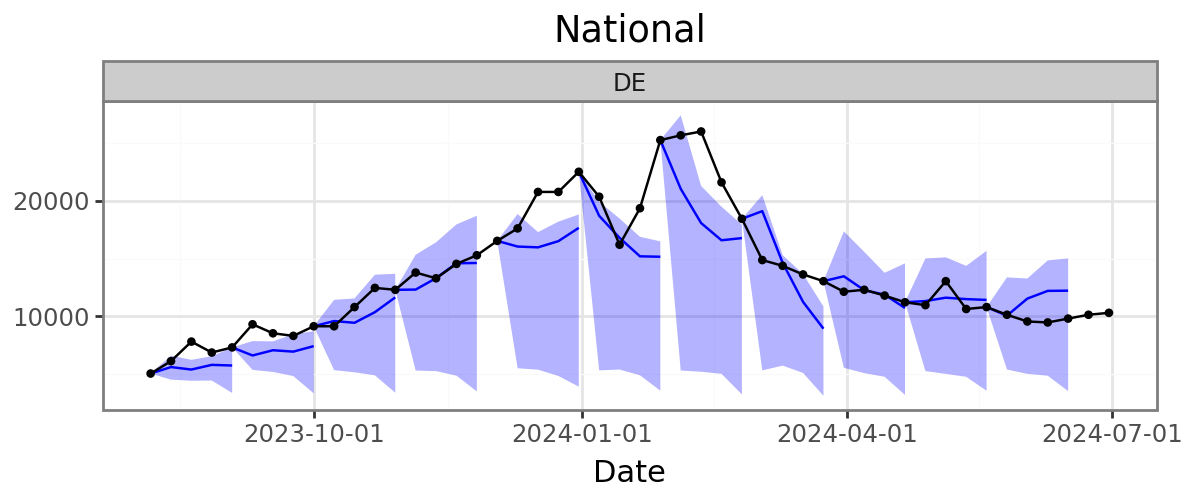

In [70]:
plot_forecasts(df_plot, 'national', start=1, stride=4)

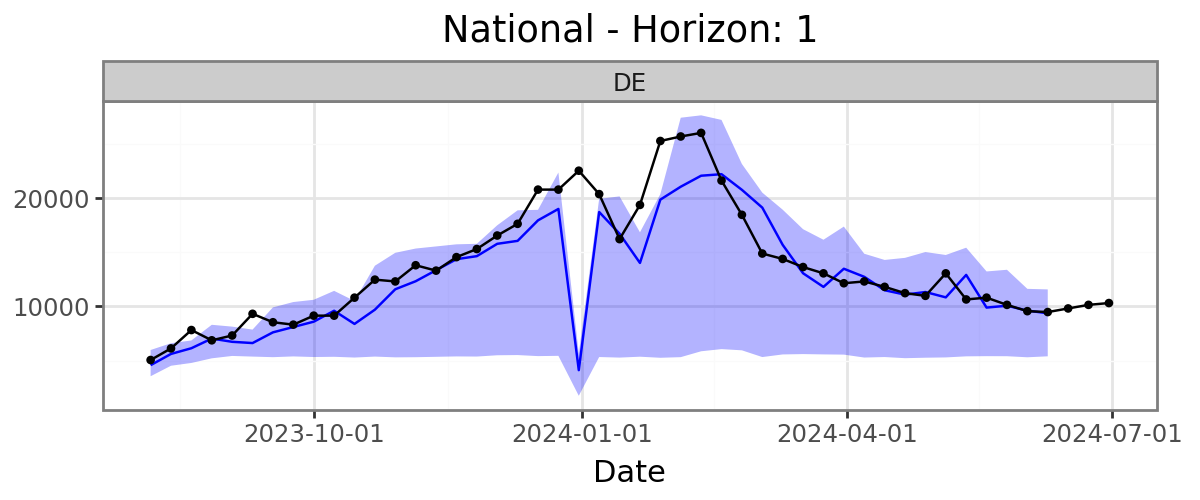

In [71]:
plot_forecasts(df_plot, 'national', horizon=1)

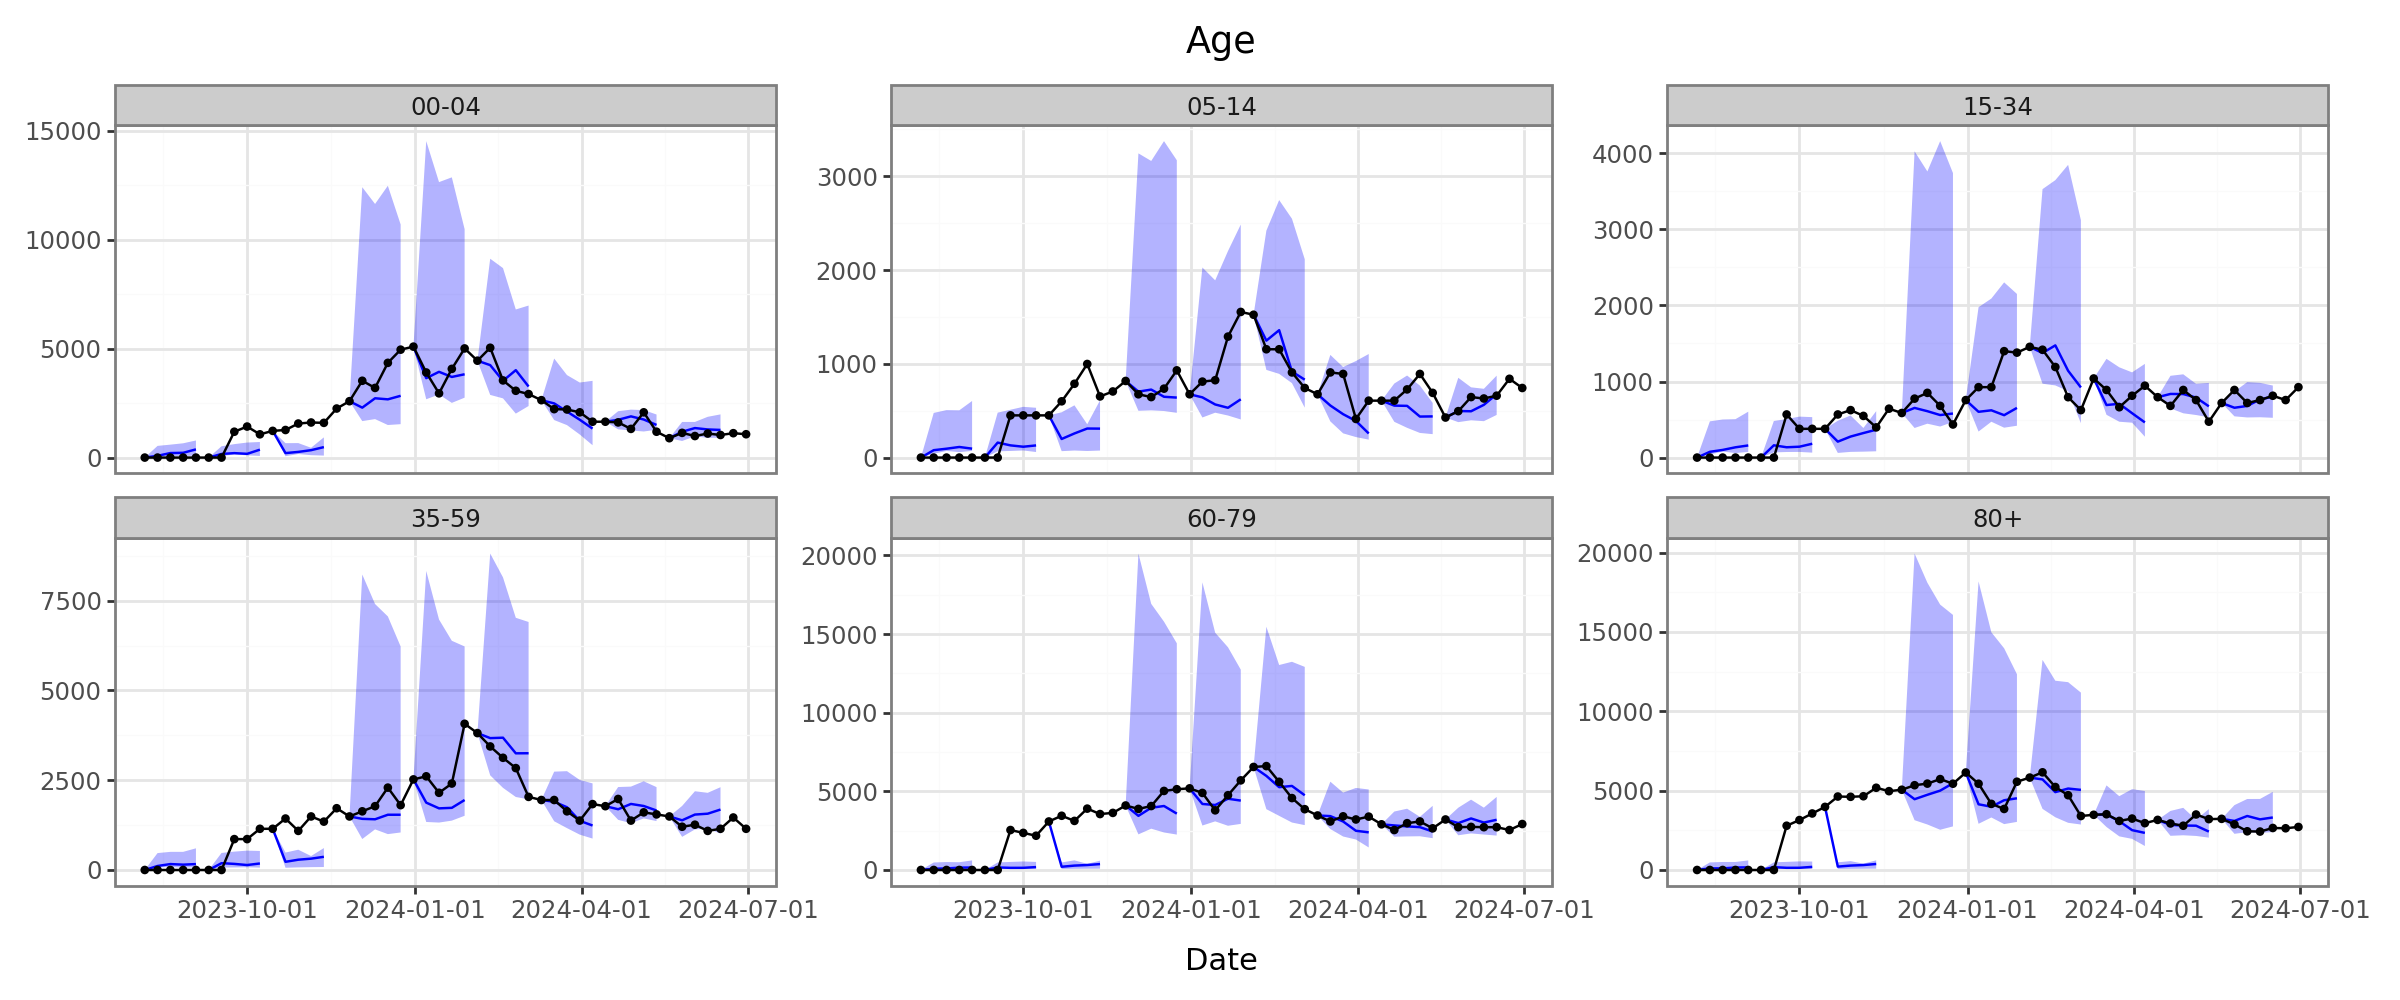

In [72]:
plot_forecasts(df_plot, 'age', start=1)

### Global, covariates, lag 8

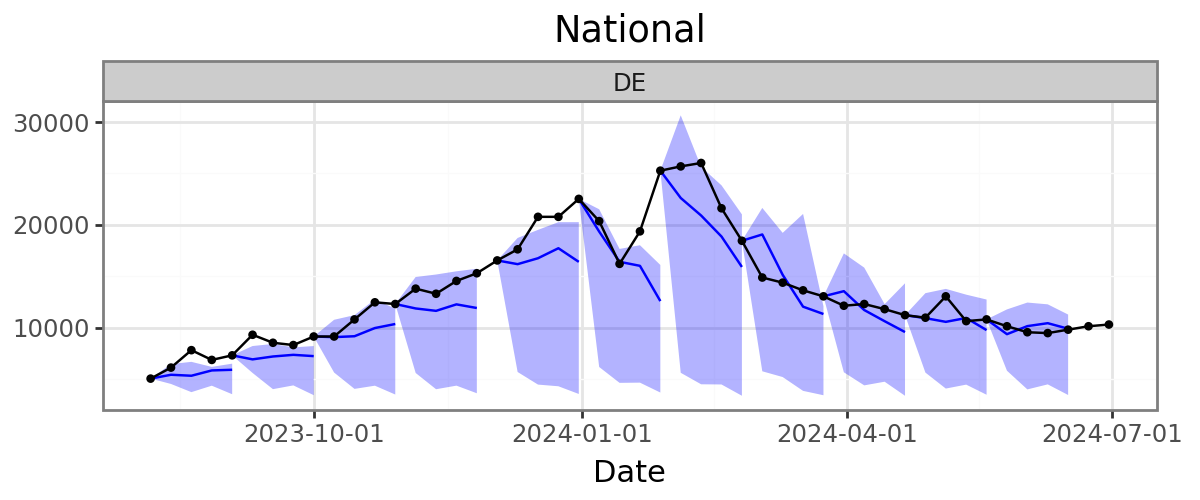

In [32]:
plot_forecasts(df_plot, 'national', start=1, stride=4)

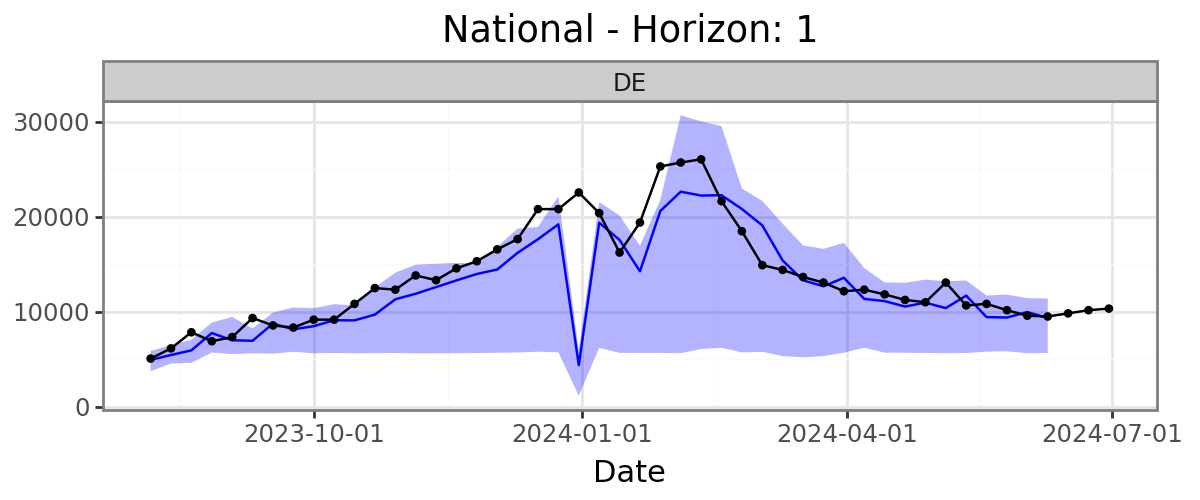

In [33]:
plot_forecasts(df_plot, 'national', horizon=1)

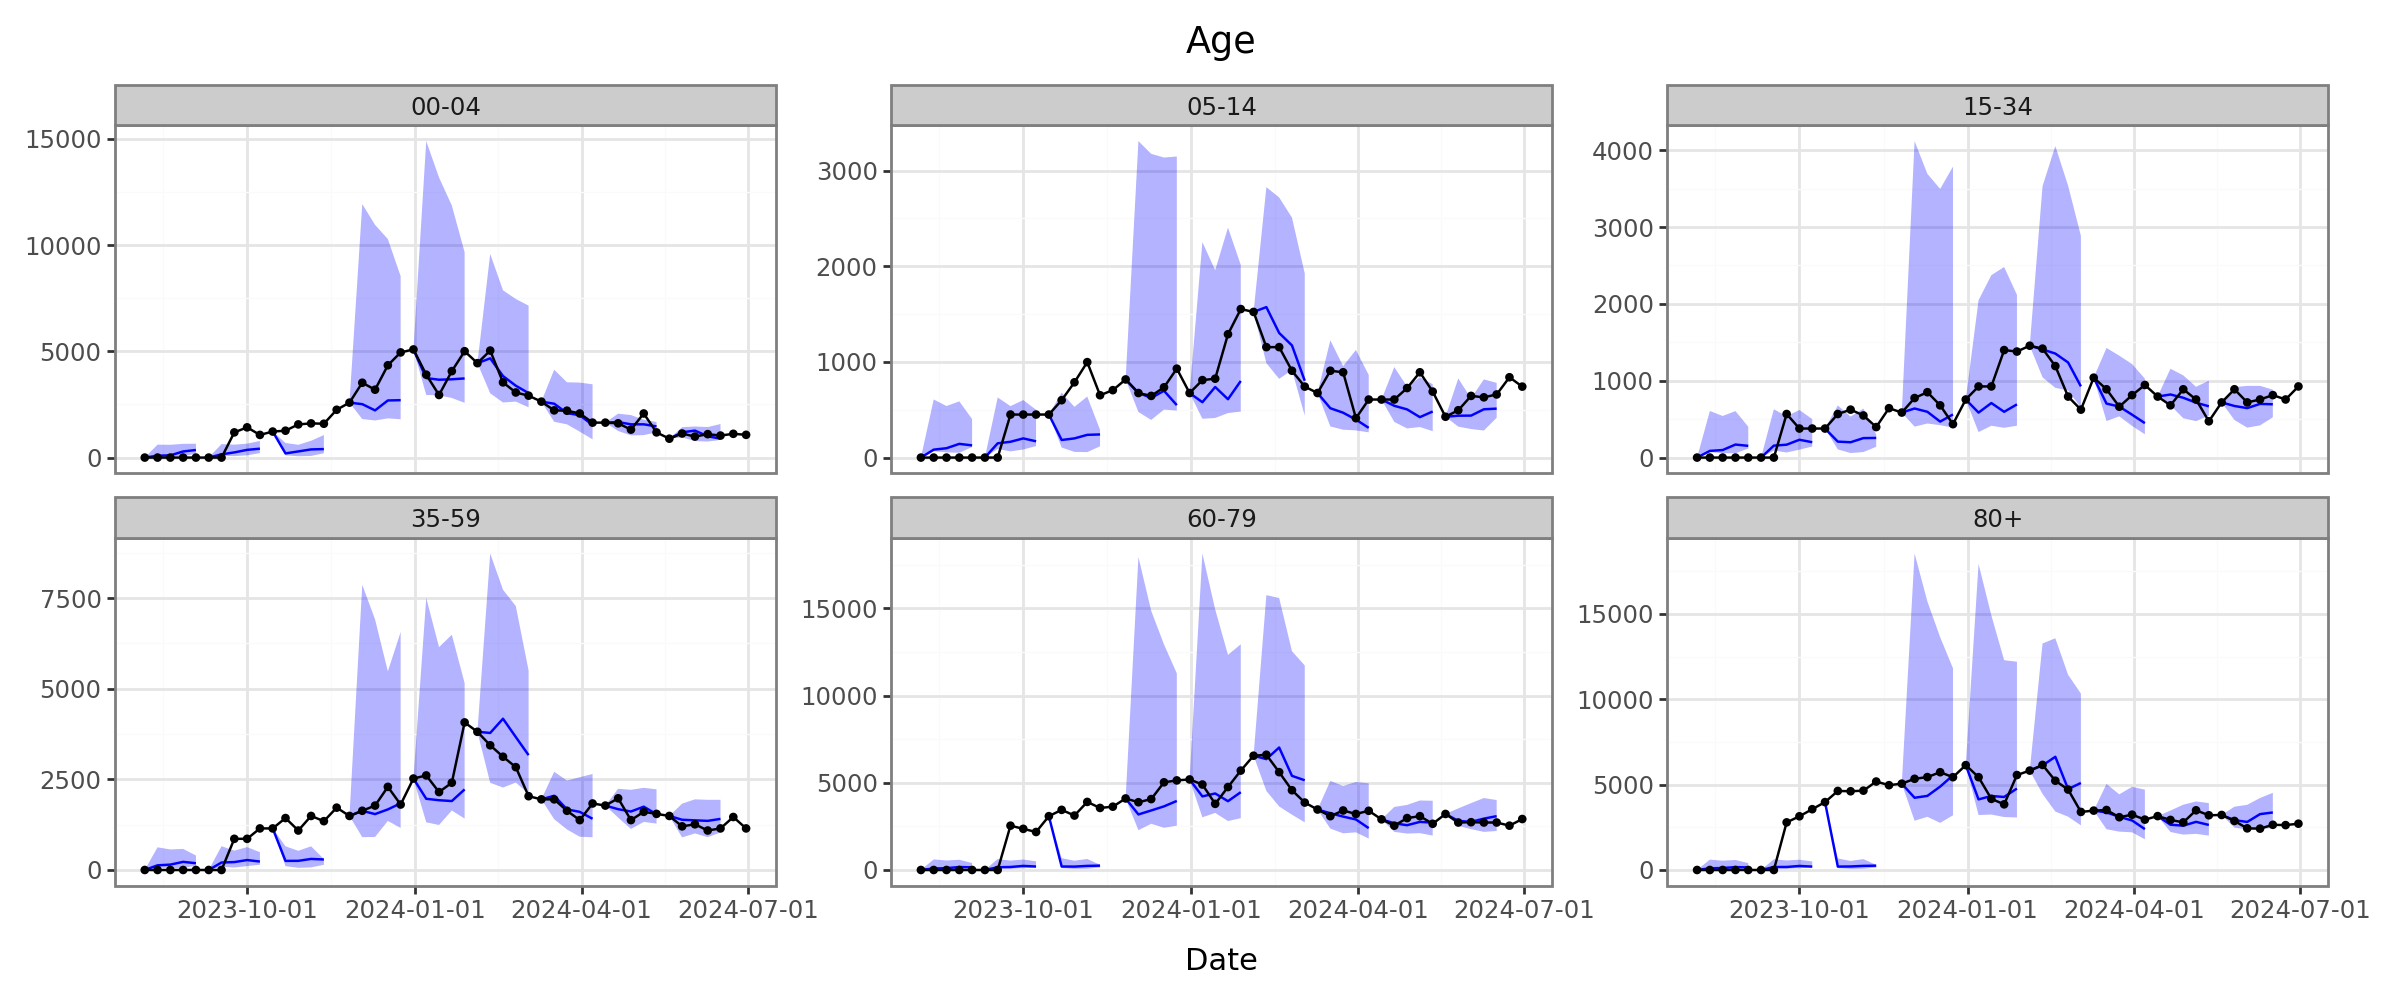

In [34]:
plot_forecasts(df_plot, 'age', start=1)

### Global, covariates

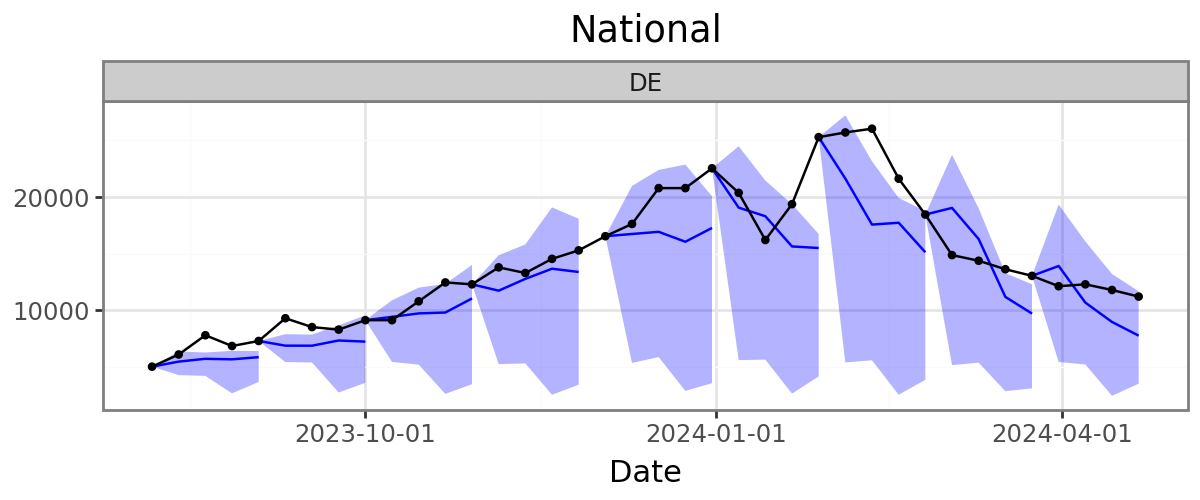

In [53]:
plot_forecasts(df_plot, 'national', start=1, stride=4)

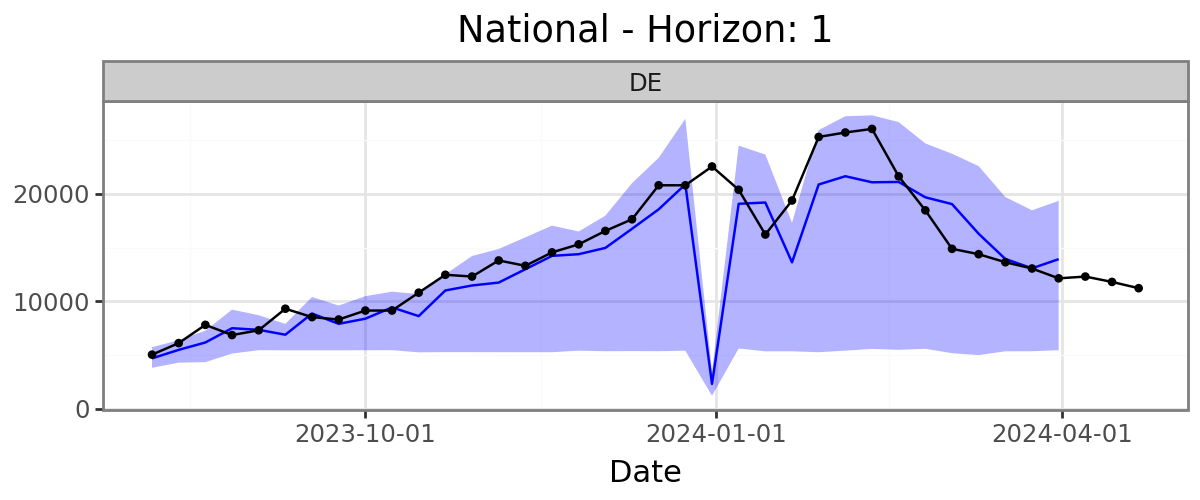

In [54]:
plot_forecasts(df_plot, 'national', horizon=1)

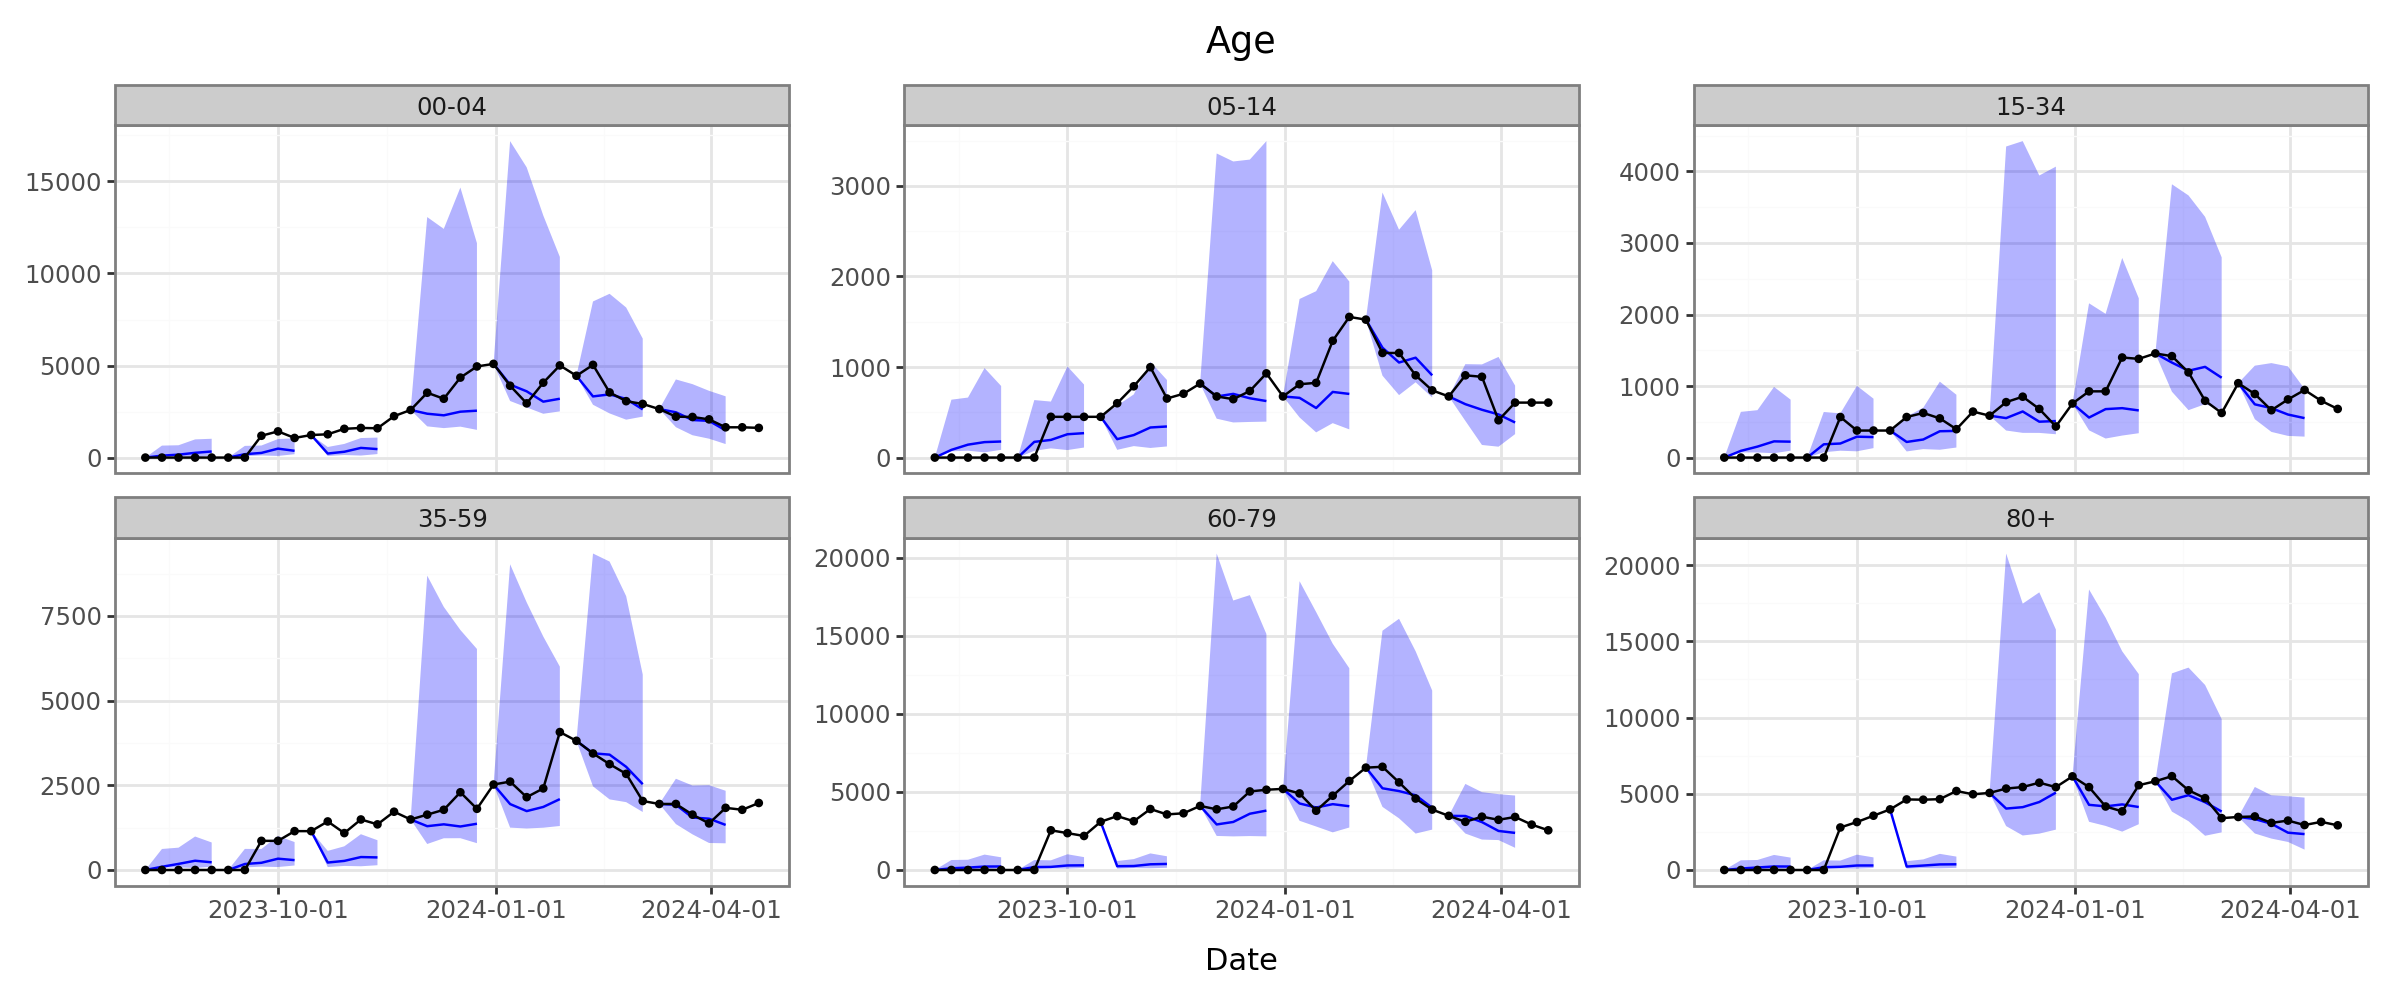

In [56]:
plot_forecasts(df_plot, 'age', start=1)

### Global, no covariates

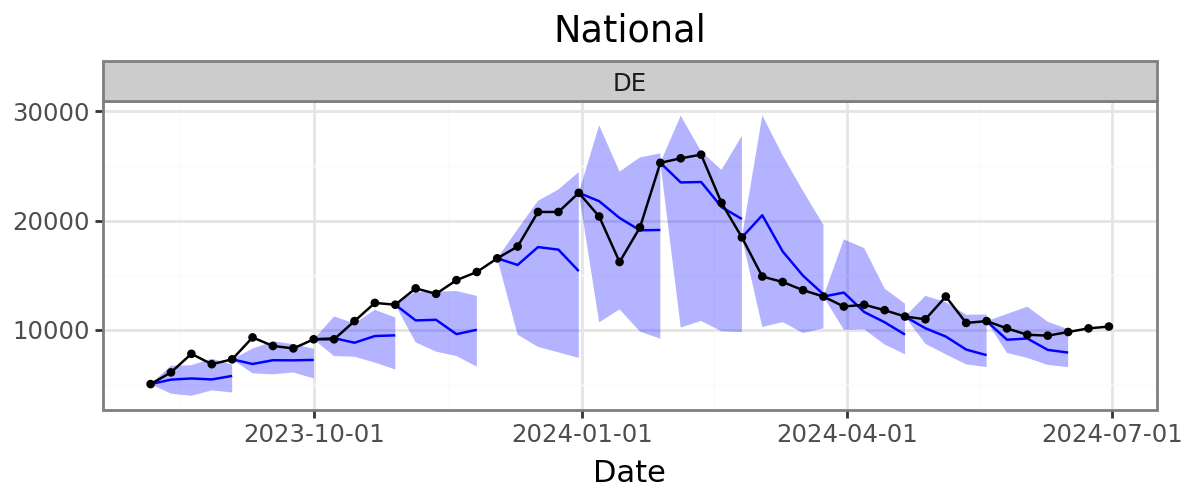

In [96]:
plot_forecasts(df_plot, 'national', start=1, stride=4)

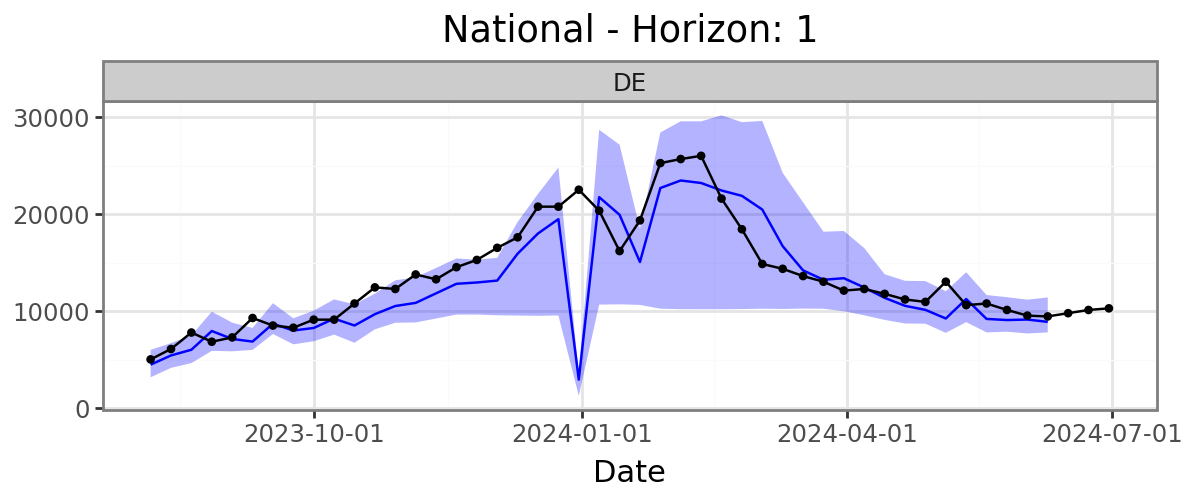

In [97]:
plot_forecasts(df_plot, 'national', horizon=1)

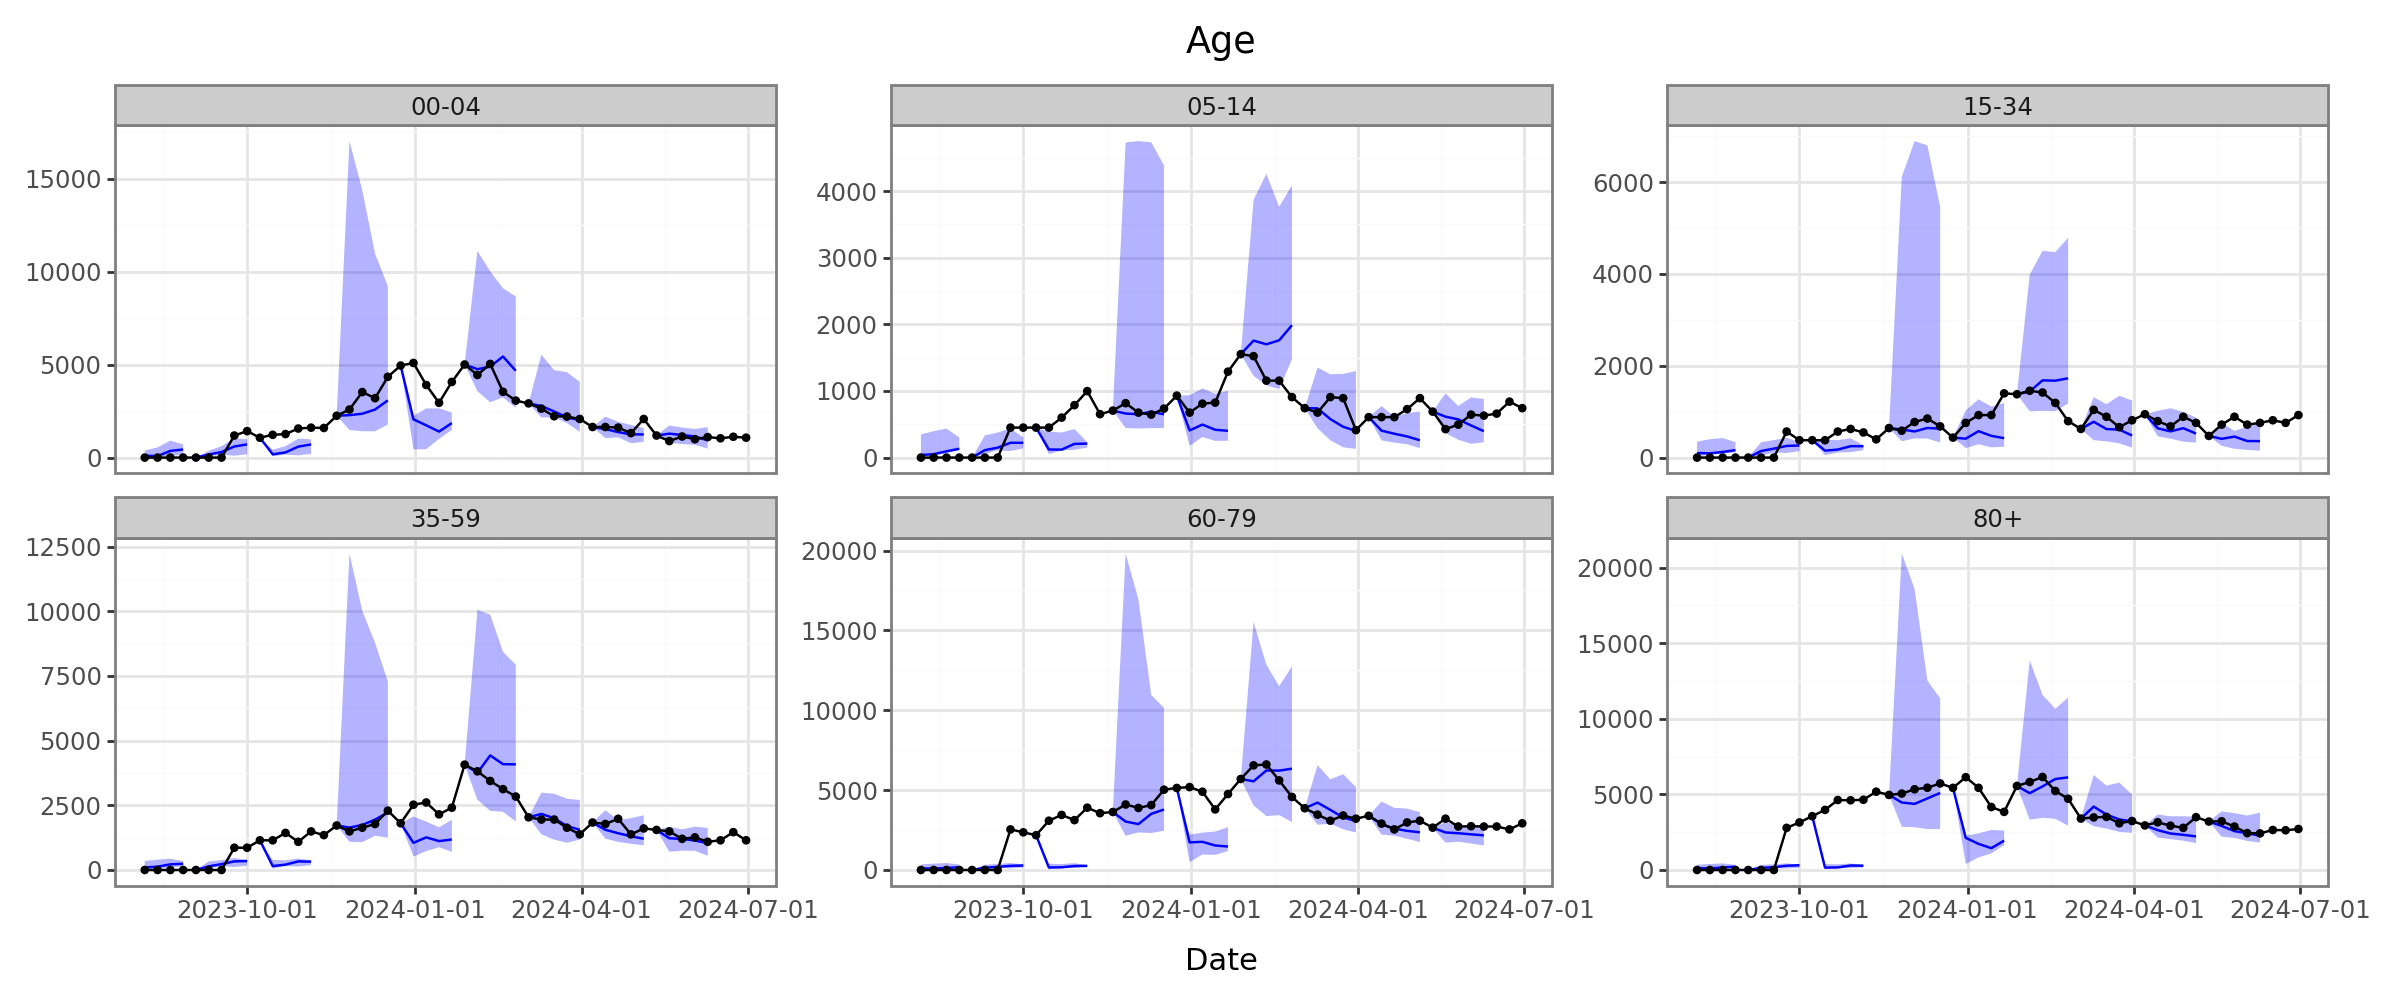

In [98]:
plot_forecasts(df_plot, 'age')